In [1]:
import numpy as np
import matplotlib.pyplot as plt
import read_chroma
import plot
import peak_detection
import projection
import peak_simulation
import random
import utils
import importlib
import sklearn
from sklearn.cluster import DBSCAN
import mass_spec
from skimage.segmentation import watershed
from scipy import ndimage as ndi
import integration
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import random
import baseline_correction

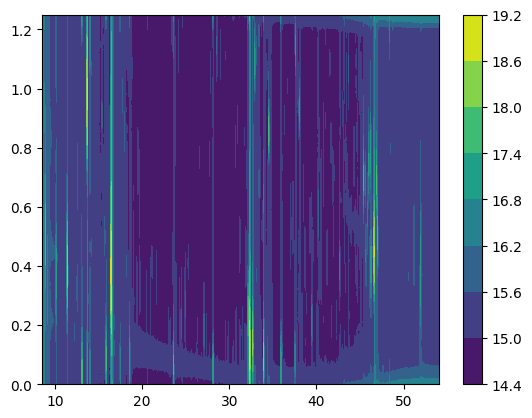

In [2]:
chromato_obj=read_chroma.read_chroma('./data/ELO_CDF/model.cdf',mod_time= 1.25)
chromato, time_rn, spectra_obj=chromato_obj
plot.visualizer(chromato_obj=(chromato,time_rn))

In [3]:
nb_mass=100

In [4]:
mass_values = np.linspace(0, nb_mass-1, nb_mass).astype(int)

In [5]:
importlib.reload(peak_simulation)
importlib.reload(mass_spec)

<module 'mass_spec' from 'c:\\Users\\33631\\Desktop\\stage\\pic\\mass_spec.py'>

In [6]:
importlib.reload(peak_simulation)
new_chromato_TIC, new_chromato_cube, params=peak_simulation.create_chromato_cube(chromato.shape, 3, mu_center=[], center_dist=1, size=80)
print(params['peaks_mu'])

spectrum shape:  383
43 499
cube shape:  (2187, 150, 457)


c:\Users\33631\Desktop\stage\pic\peak_simulation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spectra=np.array(spectra)


[[1481, 54], [1482, 53]]


In [7]:
new_chromato_cube.shape

(457, 2187, 150)

In [8]:
peaks_mu_in_chromato=projection.matrix_to_chromato(np.array(params['peaks_mu']), time_rn, 1.25, chromato.shape)
peaks_center_in_chromato=points=projection.matrix_to_chromato(np.array([params['peaks_center']]), time_rn, 1.25, chromato.shape)

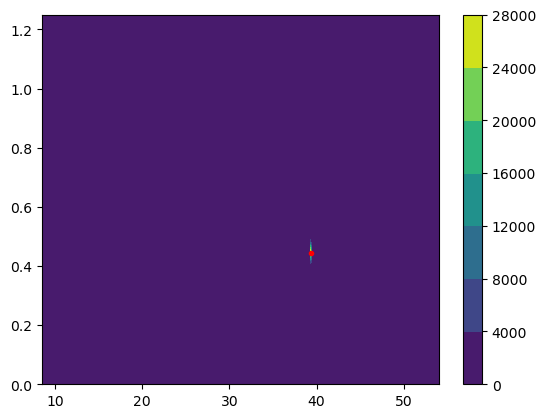

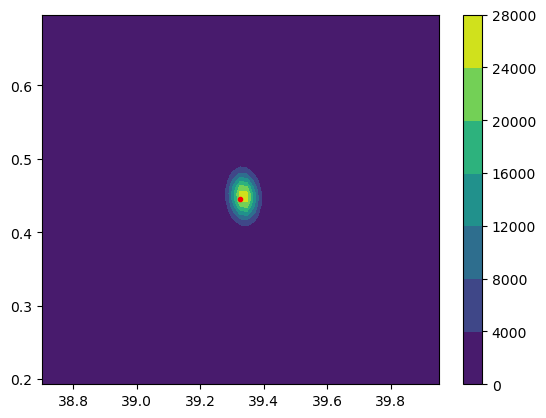

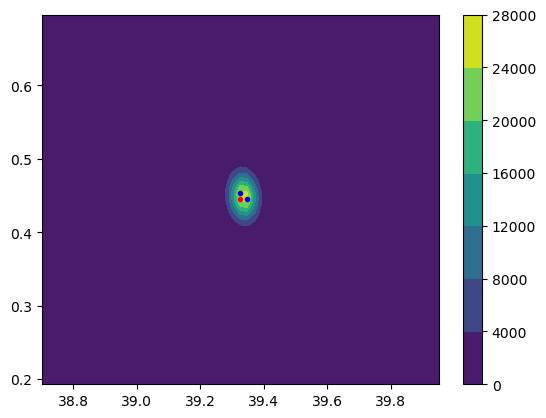

In [9]:
plot.visualizer(chromato_obj=(new_chromato_TIC,time_rn), log_chromato=False, points=peaks_center_in_chromato)
plot.visualizer(chromato_obj=(new_chromato_TIC, time_rn), log_chromato=False, points=peaks_center_in_chromato,center_pt=params['peaks_center'], center_pt_window_1=30,center_pt_window_2=30)
plot.visualizer(chromato_obj=(new_chromato_TIC, time_rn), log_chromato=False, contour=peaks_mu_in_chromato, points=peaks_center_in_chromato, center_pt=params['peaks_center'], center_pt_window_1=30,center_pt_window_2=30)

In [10]:
u = peak_detection.peak_detection(chromato_obj=(new_chromato_TIC, time_rn, spectra_obj), spectra=None, chromato_cube=None, seuil=0.1, ABS_THRESHOLDS=None, method='peak_local_max')
u_in_chromato=projection.matrix_to_chromato(u, time_rn, 1.25, chromato.shape)
u, u_in_chromato

(array([[1482,   53]], dtype=int64), array([[39.34665805,  0.44463087]]))

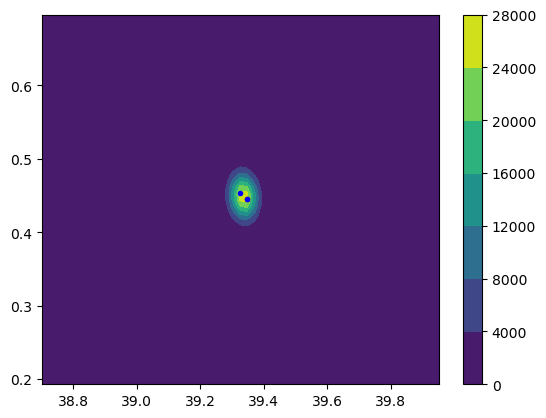

In [11]:
plot.visualizer(chromato_obj=(new_chromato_TIC, time_rn), log_chromato=False, points=u_in_chromato,contour=peaks_mu_in_chromato, center_pt=params['peaks_center'], center_pt_window_1=30,center_pt_window_2=30)


In [12]:
mass_values = np.linspace(0, nb_mass-1, nb_mass).astype(int)

In [13]:
cds = np.array(integration.tmp(new_chromato_TIC, u, u[0], threshold=0.3))

In [14]:
centers, nb_components=integration.estimate_peaks_center_bic(cds, num_components=2)
centers, nb_components

(array([[1481.5       ,   55.20249814],
        [1481.5       ,   51.79750186]]),
 2)

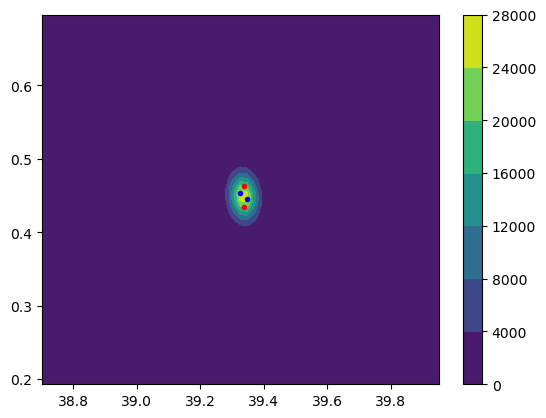

In [15]:
centers_in_chromato=projection.matrix_to_chromato(centers, time_rn, 1.25, chromato.shape)
plot.visualizer(chromato_obj=(new_chromato_TIC, time_rn), log_chromato=False, points=centers_in_chromato,contour=peaks_mu_in_chromato, center_pt=params['peaks_center'], center_pt_window_1=30,center_pt_window_2=30)

In [17]:
centers, nb_components=integration.estimate_peaks_center_with_dist(cds, new_chromato_cube, mass_values, num_components=None)
centers, nb_components

[1481   51] [1481   55]


AssertionError: Input arguments 'mz' and 'intensities' should be the same shape.

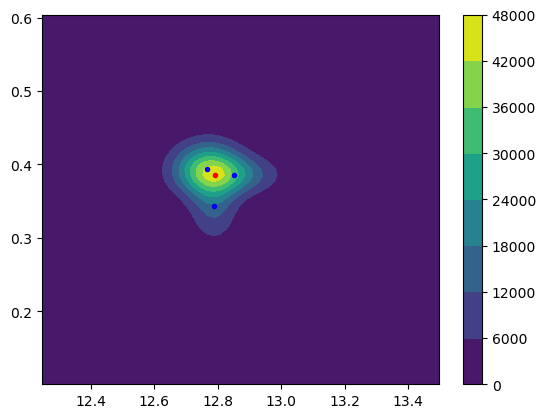

In [42]:
centers_in_chromato=projection.matrix_to_chromato(centers, time_rn, 1.25, chromato.shape)
plot.visualizer(chromato_obj=(new_chromato_TIC, time_rn), log_chromato=False, points=centers_in_chromato,contour=peaks_mu_in_chromato, center_pt=params['peaks_center'], center_pt_window_1=30,center_pt_window_2=30)

# Benchmark Gaussian Mixture nb component selection methods

In [43]:
nb_chromato=50
nb_mass=200

mass_values = np.linspace(0, nb_mass-1, nb_mass).astype(int)
error=[]
nbs_peak=[]
peaks_mu=[]
peaks_sigma=[]

peak_detection_cd=[]
gm_bic_cd=[]
gm_dist_cd=[]
gm_aic_cd=[]


peak_detection_recall=[]
gm_bic_recall=[]
gm_dist_recall=[]
gm_aic_recall=[]

chromatos=[]


for i in range(nb_chromato):

    nb_peak=random.randint(1,3)
    nbs_peak.append(nb_peak)
    peak_sigma=random.uniform(1, 7)
    peaks_sigma.append(peak_sigma)
    new_chromato_TIC, new_chromato_cube, params=peak_simulation.create_chromato_cube(chromato.shape, nb_peak, center_sigma=peak_sigma, nb_mass=nb_mass, size=80)
    peaks_mu.append(params['peaks_mu'])
    u = peak_detection.peak_detection(chromato_obj=(new_chromato_TIC, time_rn, spectra_obj), spectra=None, chromato_cube=None, seuil=0.1, ABS_THRESHOLDS=None, method='peak_local_max')
    peaks_bic=[]
    peaks_dist=[]
    peaks_aic=[]

    chromatos.append(new_chromato_TIC)
    for k in range(len(u)):

        cds = np.array(integration.tmp(new_chromato_TIC, u, u[k], threshold=0.3))
        centers_bic, nb_components_bic=integration.estimate_peaks_center_bic(cds, num_components=None)
        centers_dist, nb_components_dist=integration.estimate_peaks_center_with_dist(cds, new_chromato_cube, mass_values, num_components=None)
        centers_aic, nb_components_bic=integration.estimate_peaks_center_aic(cds, num_components=None)

        peaks_bic.append(centers_bic)
        peaks_dist.append(centers_dist)
        peaks_aic.append(centers_aic)


    peaks_bic=np.concatenate(peaks_bic)
    peaks_dist=np.concatenate(peaks_dist)
    peaks_aic=np.concatenate(peaks_aic)


    gm_aic_recall.append(len(peaks_aic))
    gm_bic_recall.append(len(peaks_bic))
    gm_dist_recall.append(len(peaks_dist))
    peak_detection_recall.append(len(u))

    gm_aic_cd.append(peaks_aic)
    gm_bic_cd.append(peaks_bic)
    gm_dist_cd.append(peaks_dist)
    peak_detection_cd.append(u)

peak_detection_cd=np.array(peak_detection_cd)
gm_bic_cd=np.array(gm_bic_cd)
gm_dist_cd=np.array(gm_dist_cd)
gm_aic_cd=np.array(gm_aic_cd)

peak_detection_recall=np.array(peak_detection_recall)
gm_bic_recall=np.array(gm_bic_recall)
gm_dist_recall=np.array(gm_dist_recall)
gm_aic_recall=np.array(gm_aic_recall)


[1310.8506422377436, 1324.7944787263684, 1338.6919925434781]
[1387   84] [1391   81]
2023-05-30 15:50:53,508:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-05-30 15:50:53,511:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
4
[1386   80] [1392   81]
2023-05-30 15:50:53,528:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-05-30 15:50:53,531:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
[1386   80] [1388   85]
2023-05-30 15:50:53,536:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-05-30 15:50:53,538:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
[1392   81] [1388   85]
2023-05-30 15:50:53,543:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-05-30 15:50:53,546:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
4
[1.0, 0.8935779340004022, 0.9051123042247945]
[1296.709073551232, 1293.683027616043, 1290.0015779752375

C:\Users\33631\AppData\Local\Temp\ipykernel_200284\3616888269.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_detection_cd=np.array(peak_detection_cd)
C:\Users\33631\AppData\Local\Temp\ipykernel_200284\3616888269.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gm_bic_cd=np.array(gm_bic_cd)
C:\Users\33631\AppData\Local\Temp\ipykernel_200284\3616888269.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated.

In [44]:
peak_detection_recall_ratio=(peak_detection_recall / nbs_peak)
gm_bic_recall_ratio=(gm_bic_recall / nbs_peak)
gm_dist_recall_ratio=(gm_dist_recall / nbs_peak)
gm_aic_recall_ratio=(gm_aic_recall / nbs_peak)
np.mean(peak_detection_recall_ratio),np.mean(gm_bic_recall_ratio),np.mean(gm_dist_recall_ratio),np.mean(gm_aic_recall_ratio)

(0.7399999999999999, 0.7666666666666664, 0.9033333333333333, 1.14)

In [45]:
peak_detection_recall_dist=(np.abs(peak_detection_recall - nbs_peak))
gm_bic_recall_dist=(np.abs(gm_bic_recall - nbs_peak))
gm_dist_recall_dist=(np.abs(gm_dist_recall - nbs_peak))
gm_aic_recall_dist=(np.abs(gm_aic_recall - nbs_peak))
np.mean(peak_detection_recall_dist), np.mean(gm_bic_recall_dist), np.mean(gm_dist_recall_dist), np.mean(gm_aic_recall_dist)

(0.72, 0.68, 0.54, 0.86)

recall -- nb peaks: 2 peak detection: 1 bic: 1 aic: 3 dst: 2
dist -- nb peaks: 2 peak detection: 1 bic: 1 aic: 1 dst: 0


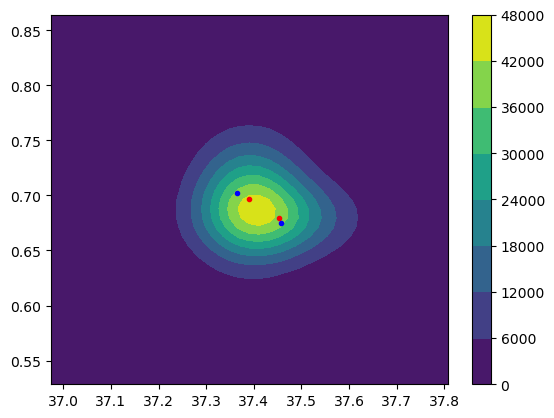

recall -- nb peaks: 2 peak detection: 1 bic: 1 aic: 3 dst: 1
dist -- nb peaks: 2 peak detection: 1 bic: 1 aic: 1 dst: 1


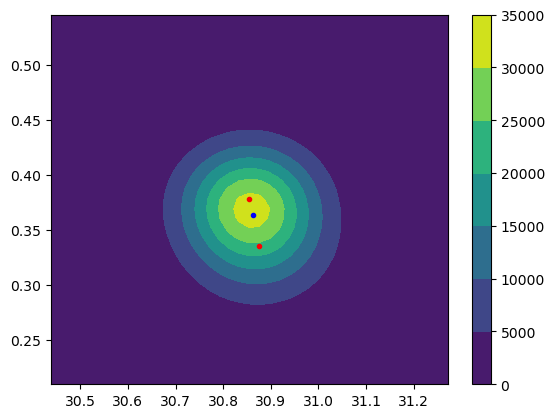

recall -- nb peaks: 2 peak detection: 2 bic: 2 aic: 4 dst: 2
dist -- nb peaks: 2 peak detection: 0 bic: 0 aic: 2 dst: 0


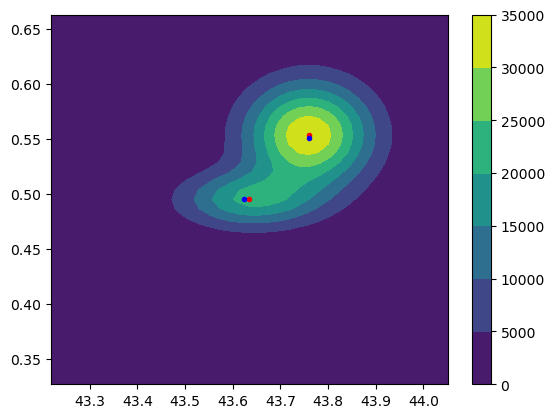

recall -- nb peaks: 1 peak detection: 1 bic: 1 aic: 1 dst: 1
dist -- nb peaks: 1 peak detection: 0 bic: 0 aic: 0 dst: 0


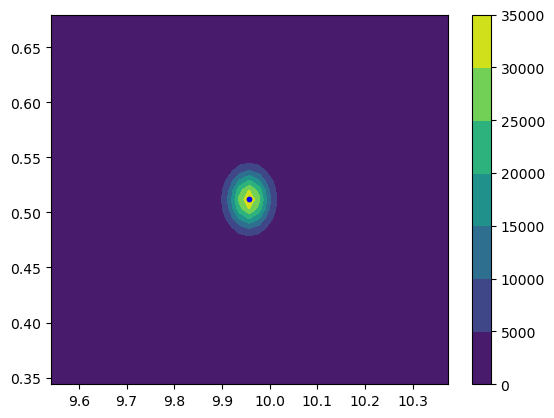

recall -- nb peaks: 2 peak detection: 1 bic: 1 aic: 3 dst: 2
dist -- nb peaks: 2 peak detection: 1 bic: 1 aic: 1 dst: 0


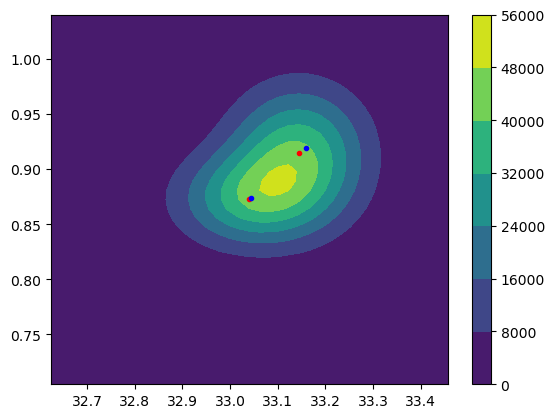

recall -- nb peaks: 1 peak detection: 1 bic: 1 aic: 1 dst: 1
dist -- nb peaks: 1 peak detection: 0 bic: 0 aic: 0 dst: 0


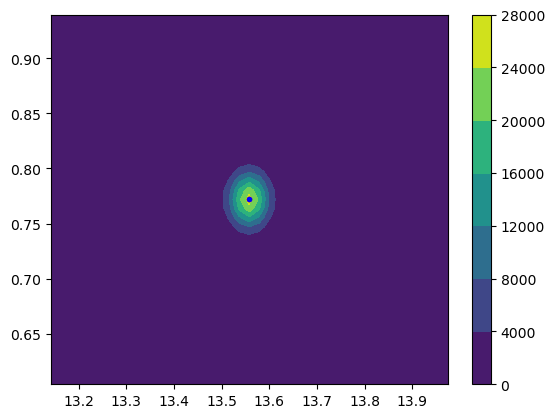

recall -- nb peaks: 3 peak detection: 1 bic: 1 aic: 3 dst: 1
dist -- nb peaks: 3 peak detection: 2 bic: 2 aic: 0 dst: 2


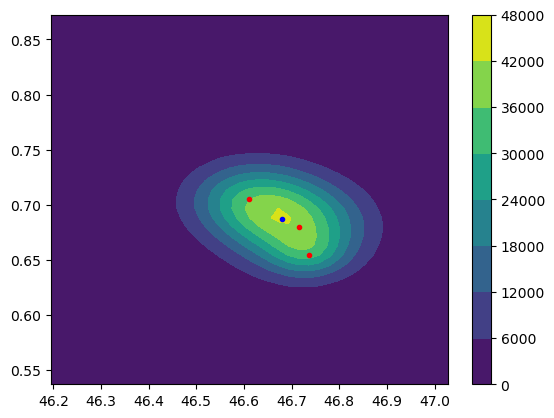

recall -- nb peaks: 1 peak detection: 1 bic: 1 aic: 1 dst: 1
dist -- nb peaks: 1 peak detection: 0 bic: 0 aic: 0 dst: 0


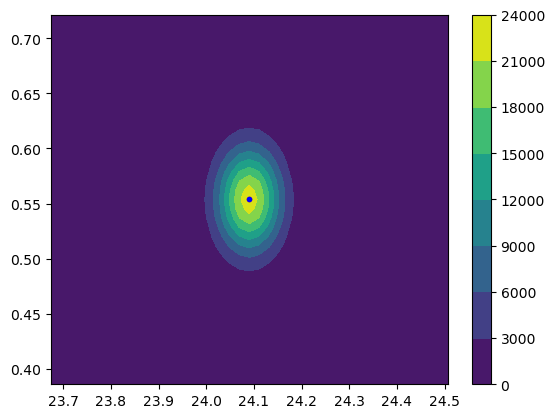

recall -- nb peaks: 3 peak detection: 1 bic: 1 aic: 2 dst: 1
dist -- nb peaks: 3 peak detection: 2 bic: 2 aic: 1 dst: 2


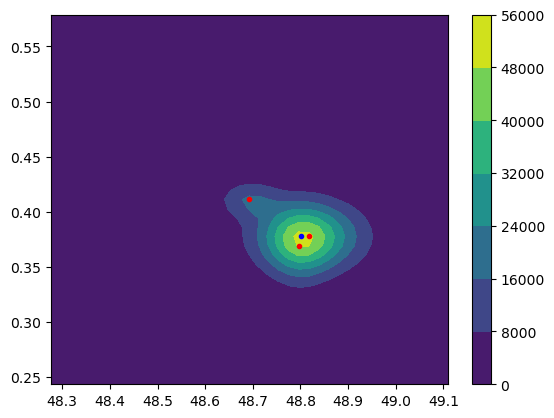

recall -- nb peaks: 3 peak detection: 2 bic: 2 aic: 6 dst: 3
dist -- nb peaks: 3 peak detection: 1 bic: 1 aic: 3 dst: 0


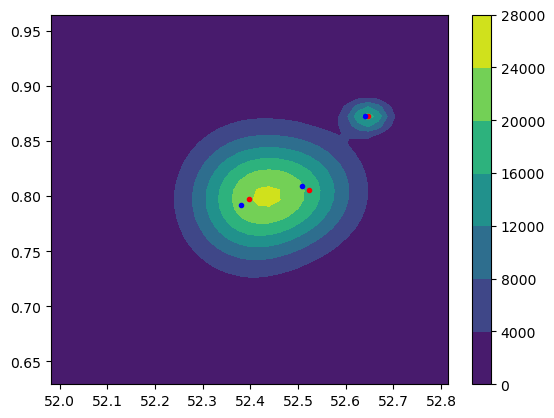

recall -- nb peaks: 2 peak detection: 2 bic: 2 aic: 2 dst: 2
dist -- nb peaks: 2 peak detection: 0 bic: 0 aic: 0 dst: 0


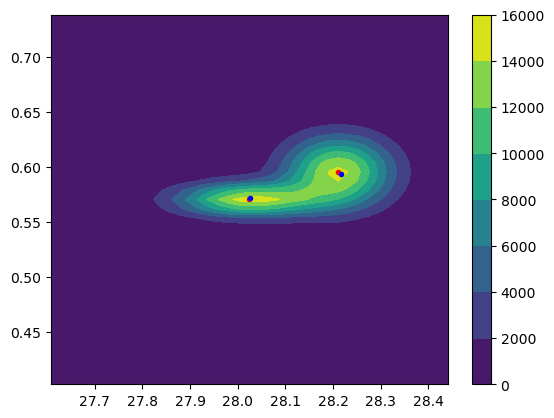

recall -- nb peaks: 3 peak detection: 1 bic: 1 aic: 1 dst: 1
dist -- nb peaks: 3 peak detection: 2 bic: 2 aic: 2 dst: 2


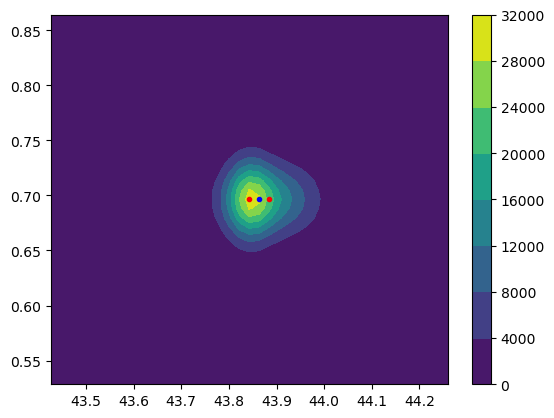

recall -- nb peaks: 3 peak detection: 1 bic: 1 aic: 1 dst: 1
dist -- nb peaks: 3 peak detection: 2 bic: 2 aic: 2 dst: 2


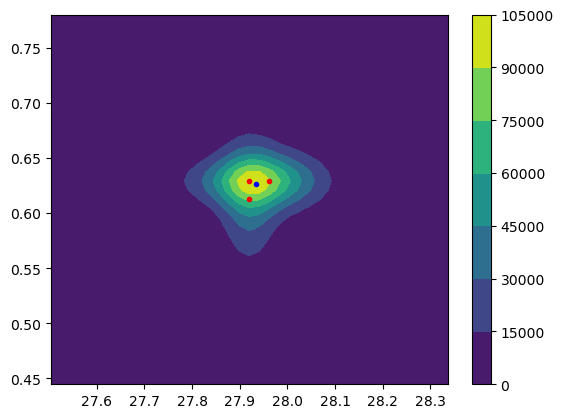

recall -- nb peaks: 2 peak detection: 2 bic: 2 aic: 2 dst: 2
dist -- nb peaks: 2 peak detection: 0 bic: 0 aic: 0 dst: 0


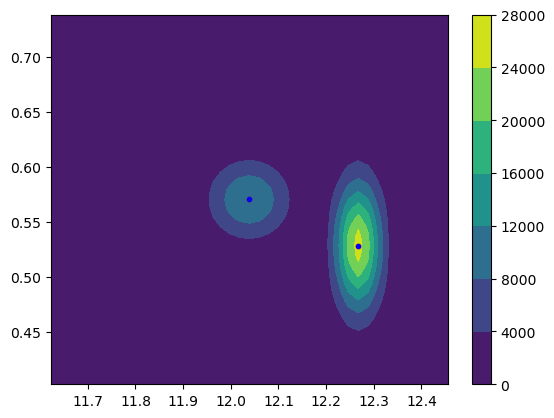

recall -- nb peaks: 1 peak detection: 1 bic: 1 aic: 1 dst: 1
dist -- nb peaks: 1 peak detection: 0 bic: 0 aic: 0 dst: 0


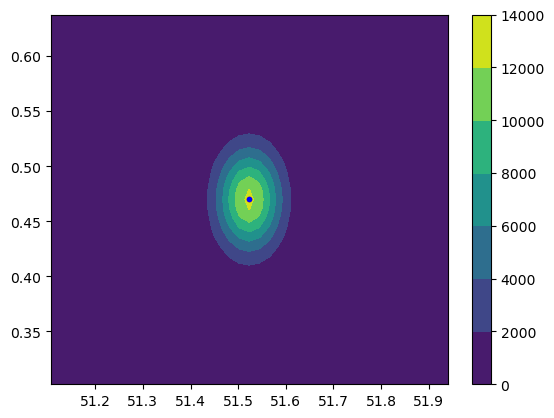

recall -- nb peaks: 3 peak detection: 1 bic: 2 aic: 2 dst: 3
dist -- nb peaks: 3 peak detection: 2 bic: 1 aic: 1 dst: 0


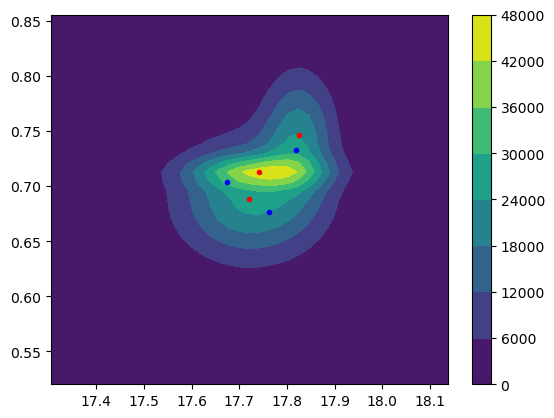

recall -- nb peaks: 2 peak detection: 1 bic: 1 aic: 1 dst: 2
dist -- nb peaks: 2 peak detection: 1 bic: 1 aic: 1 dst: 0


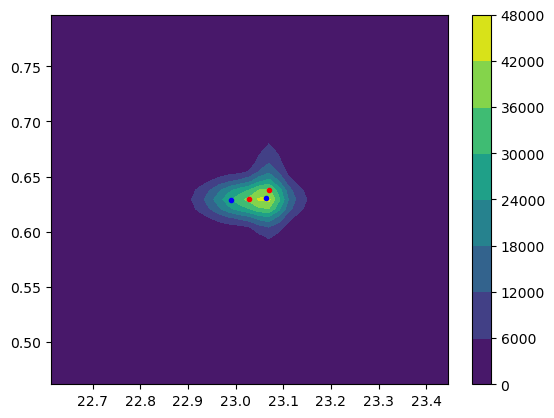

recall -- nb peaks: 2 peak detection: 1 bic: 1 aic: 1 dst: 1
dist -- nb peaks: 2 peak detection: 1 bic: 1 aic: 1 dst: 1


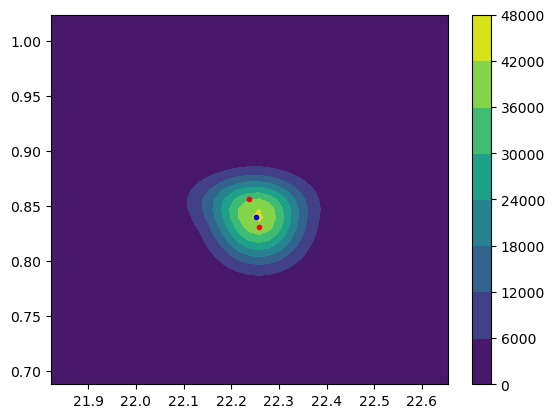

recall -- nb peaks: 1 peak detection: 1 bic: 1 aic: 1 dst: 1
dist -- nb peaks: 1 peak detection: 0 bic: 0 aic: 0 dst: 0


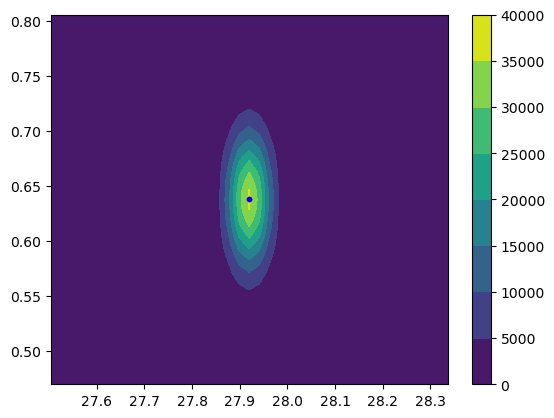

recall -- nb peaks: 3 peak detection: 3 bic: 3 aic: 3 dst: 3
dist -- nb peaks: 3 peak detection: 0 bic: 0 aic: 0 dst: 0


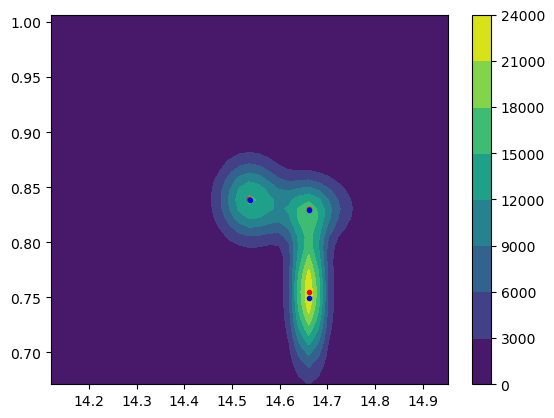

recall -- nb peaks: 3 peak detection: 1 bic: 1 aic: 1 dst: 2
dist -- nb peaks: 3 peak detection: 2 bic: 2 aic: 2 dst: 1


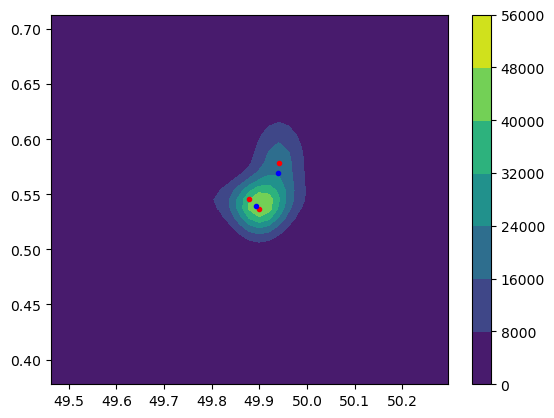

recall -- nb peaks: 3 peak detection: 2 bic: 2 aic: 3 dst: 4
dist -- nb peaks: 3 peak detection: 1 bic: 1 aic: 0 dst: 1


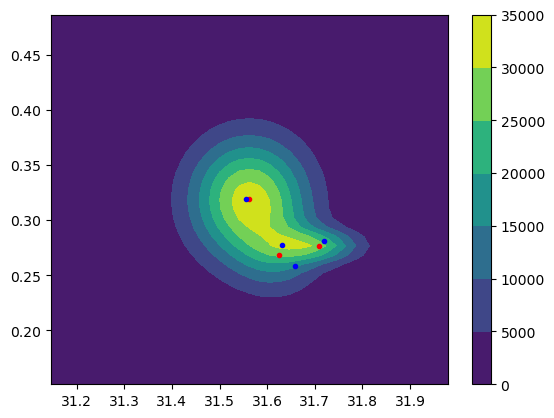

recall -- nb peaks: 3 peak detection: 2 bic: 4 aic: 2 dst: 2
dist -- nb peaks: 3 peak detection: 1 bic: 1 aic: 1 dst: 1


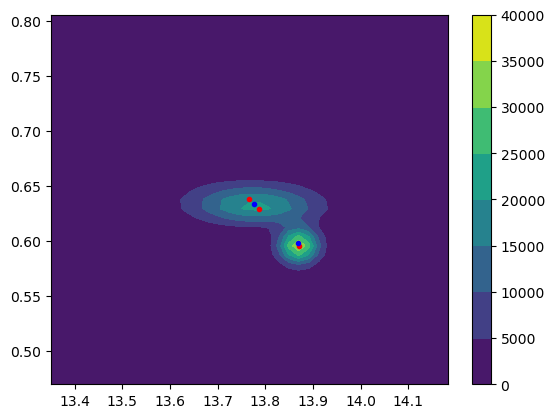

recall -- nb peaks: 3 peak detection: 2 bic: 2 aic: 4 dst: 3
dist -- nb peaks: 3 peak detection: 1 bic: 1 aic: 1 dst: 0


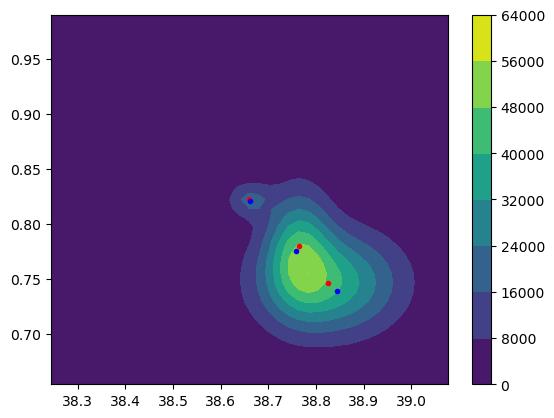

recall -- nb peaks: 3 peak detection: 2 bic: 2 aic: 4 dst: 3
dist -- nb peaks: 3 peak detection: 1 bic: 1 aic: 1 dst: 0


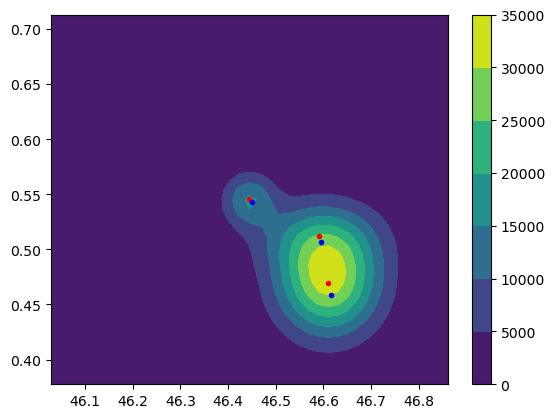

recall -- nb peaks: 1 peak detection: 1 bic: 1 aic: 3 dst: 1
dist -- nb peaks: 1 peak detection: 0 bic: 0 aic: 2 dst: 0


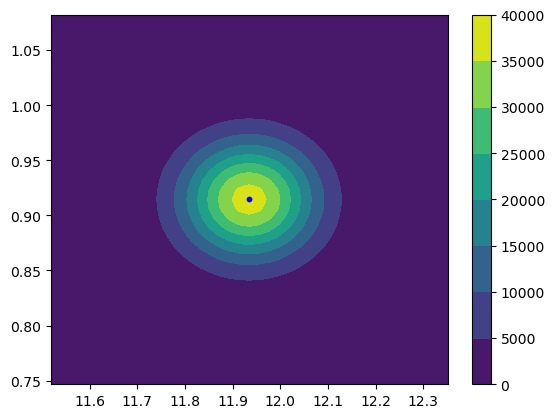

recall -- nb peaks: 1 peak detection: 1 bic: 1 aic: 1 dst: 1
dist -- nb peaks: 1 peak detection: 0 bic: 0 aic: 0 dst: 0


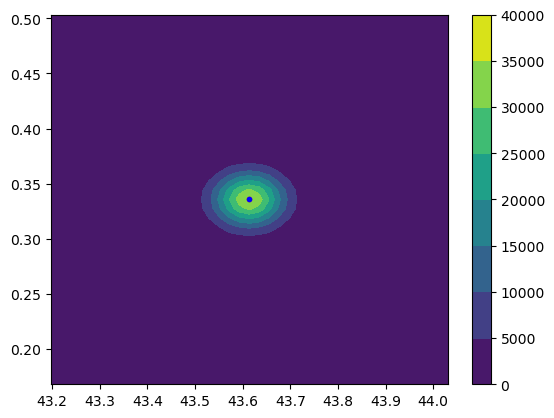

recall -- nb peaks: 3 peak detection: 1 bic: 1 aic: 1 dst: 1
dist -- nb peaks: 3 peak detection: 2 bic: 2 aic: 2 dst: 2


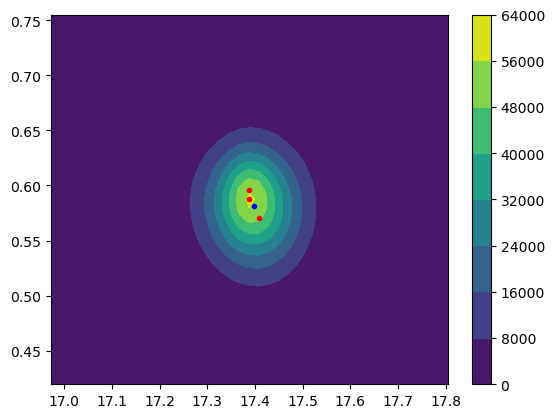

recall -- nb peaks: 1 peak detection: 1 bic: 1 aic: 3 dst: 1
dist -- nb peaks: 1 peak detection: 0 bic: 0 aic: 2 dst: 0


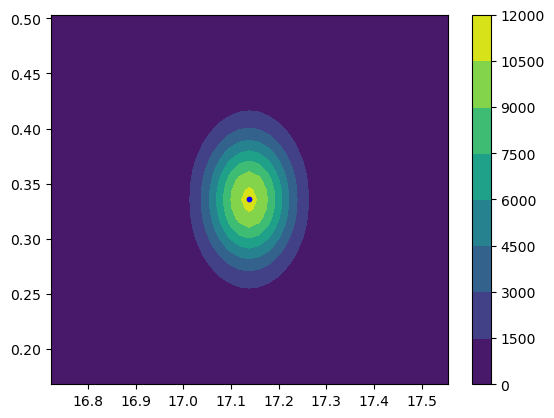

recall -- nb peaks: 1 peak detection: 1 bic: 1 aic: 1 dst: 1
dist -- nb peaks: 1 peak detection: 0 bic: 0 aic: 0 dst: 0


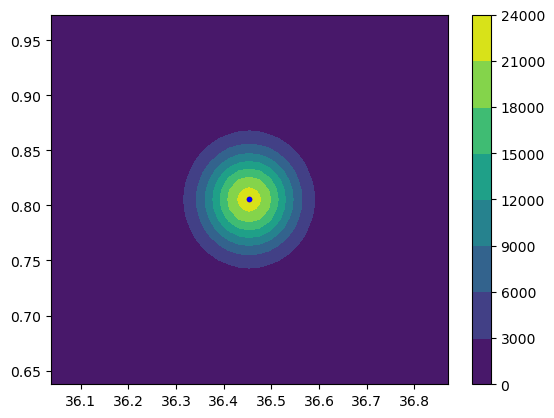

recall -- nb peaks: 1 peak detection: 1 bic: 1 aic: 1 dst: 1
dist -- nb peaks: 1 peak detection: 0 bic: 0 aic: 0 dst: 0


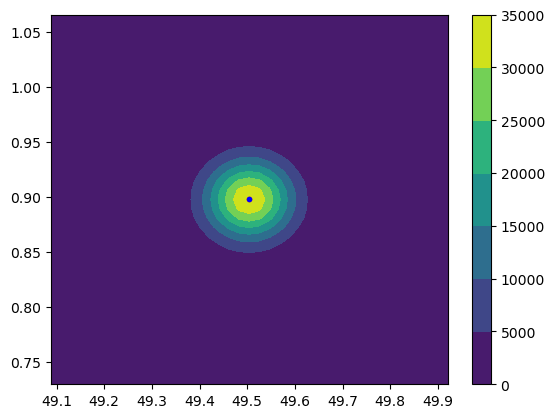

recall -- nb peaks: 2 peak detection: 2 bic: 2 aic: 2 dst: 2
dist -- nb peaks: 2 peak detection: 0 bic: 0 aic: 0 dst: 0


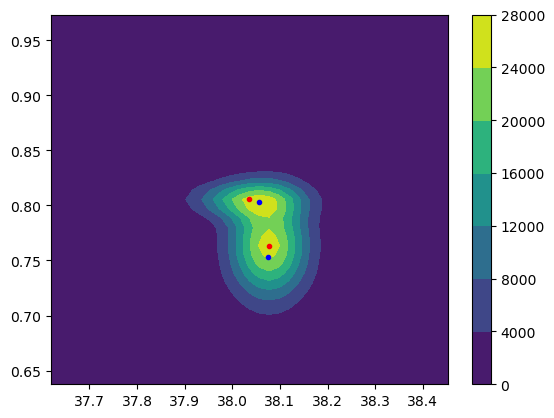

recall -- nb peaks: 3 peak detection: 1 bic: 1 aic: 1 dst: 1
dist -- nb peaks: 3 peak detection: 2 bic: 2 aic: 2 dst: 2


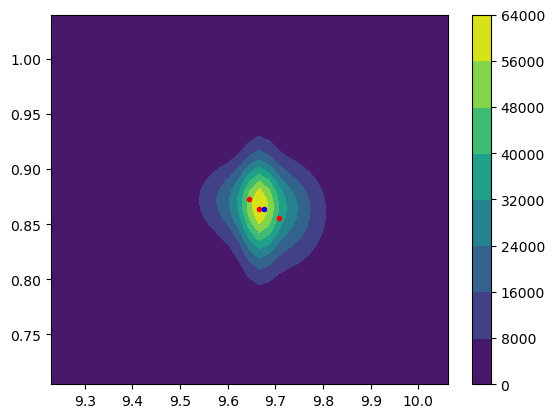

recall -- nb peaks: 1 peak detection: 1 bic: 1 aic: 1 dst: 1
dist -- nb peaks: 1 peak detection: 0 bic: 0 aic: 0 dst: 0


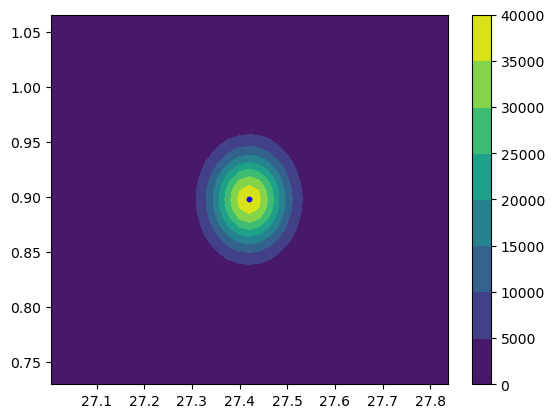

recall -- nb peaks: 2 peak detection: 2 bic: 2 aic: 2 dst: 2
dist -- nb peaks: 2 peak detection: 0 bic: 0 aic: 0 dst: 0


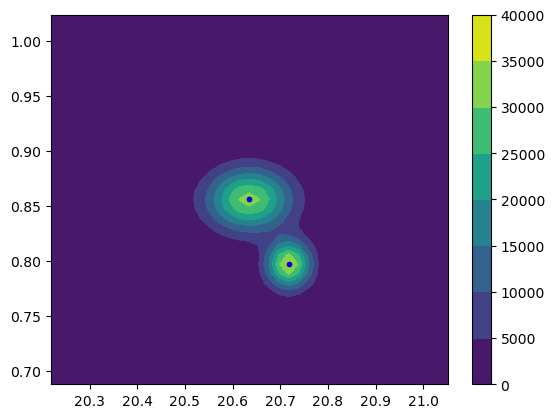

recall -- nb peaks: 3 peak detection: 2 bic: 2 aic: 2 dst: 2
dist -- nb peaks: 3 peak detection: 1 bic: 1 aic: 1 dst: 1


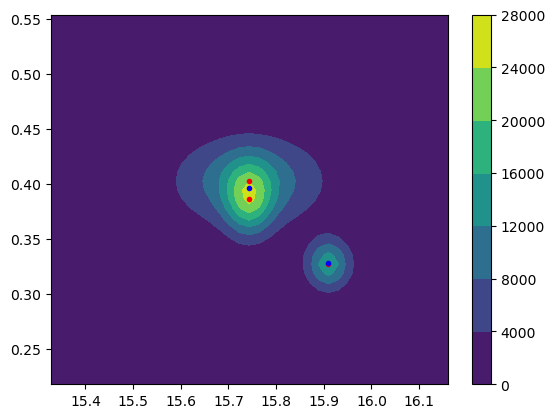

recall -- nb peaks: 1 peak detection: 1 bic: 1 aic: 3 dst: 1
dist -- nb peaks: 1 peak detection: 0 bic: 0 aic: 2 dst: 0


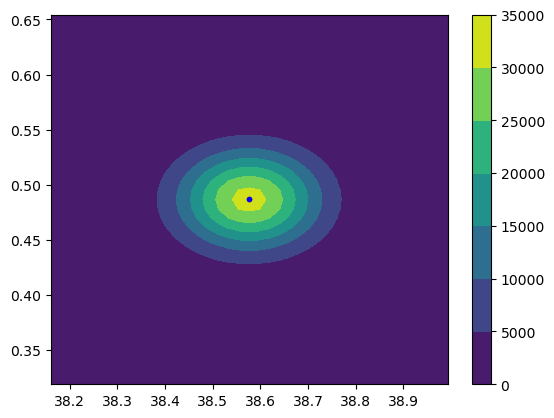

recall -- nb peaks: 2 peak detection: 1 bic: 1 aic: 2 dst: 3
dist -- nb peaks: 2 peak detection: 1 bic: 1 aic: 0 dst: 1


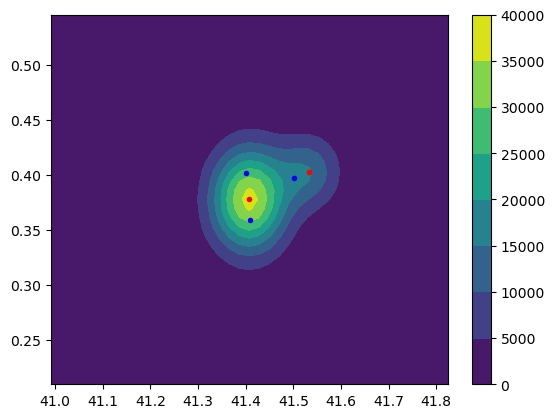

recall -- nb peaks: 3 peak detection: 1 bic: 2 aic: 3 dst: 2
dist -- nb peaks: 3 peak detection: 2 bic: 1 aic: 0 dst: 1


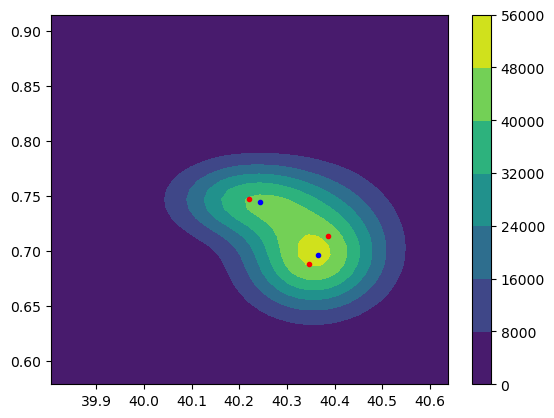

recall -- nb peaks: 1 peak detection: 1 bic: 1 aic: 1 dst: 1
dist -- nb peaks: 1 peak detection: 0 bic: 0 aic: 0 dst: 0


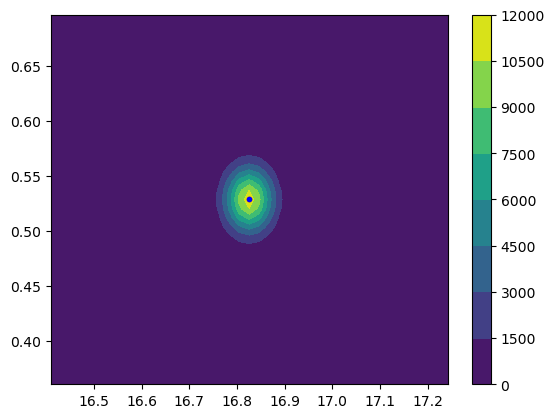

recall -- nb peaks: 2 peak detection: 2 bic: 2 aic: 3 dst: 2
dist -- nb peaks: 2 peak detection: 0 bic: 0 aic: 1 dst: 0


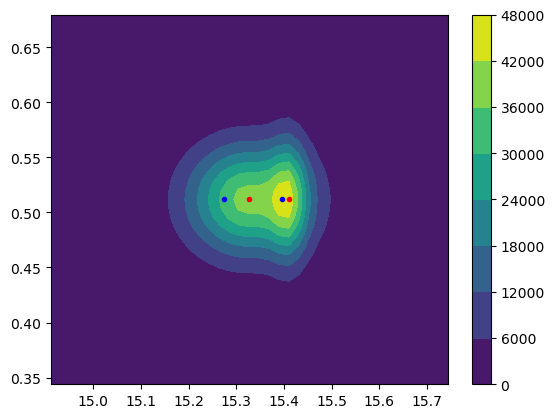

recall -- nb peaks: 3 peak detection: 1 bic: 1 aic: 1 dst: 2
dist -- nb peaks: 3 peak detection: 2 bic: 2 aic: 2 dst: 1


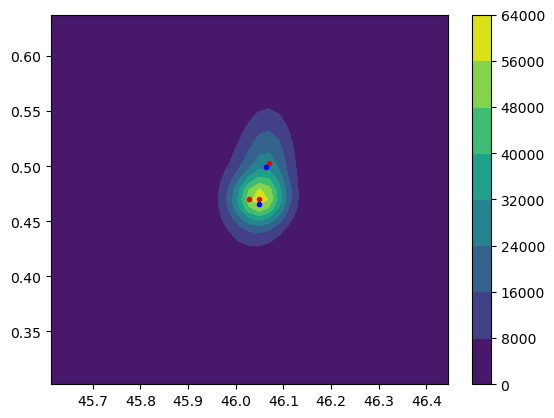

recall -- nb peaks: 1 peak detection: 1 bic: 1 aic: 1 dst: 1
dist -- nb peaks: 1 peak detection: 0 bic: 0 aic: 0 dst: 0


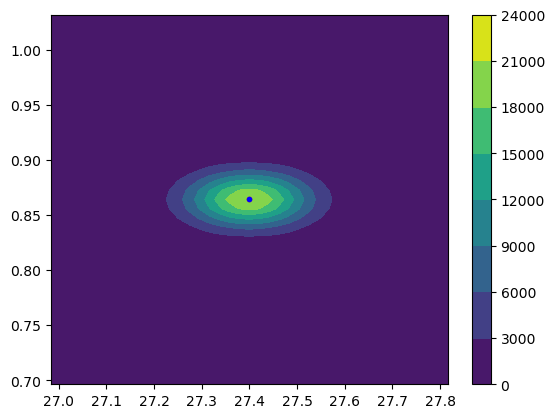

recall -- nb peaks: 1 peak detection: 1 bic: 1 aic: 3 dst: 1
dist -- nb peaks: 1 peak detection: 0 bic: 0 aic: 2 dst: 0


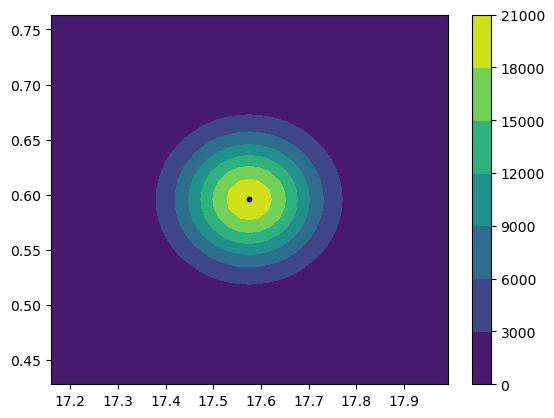

recall -- nb peaks: 3 peak detection: 3 bic: 3 aic: 3 dst: 3
dist -- nb peaks: 3 peak detection: 0 bic: 0 aic: 0 dst: 0


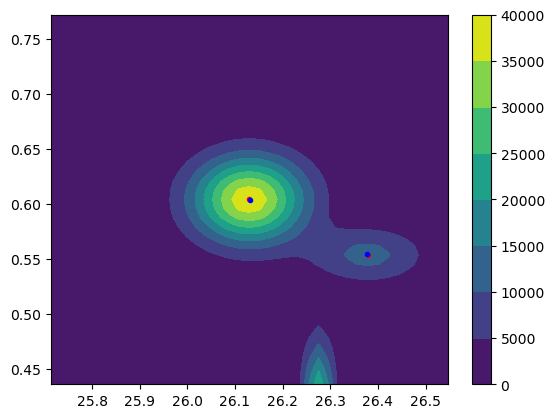

recall -- nb peaks: 3 peak detection: 1 bic: 1 aic: 1 dst: 1
dist -- nb peaks: 3 peak detection: 2 bic: 2 aic: 2 dst: 2


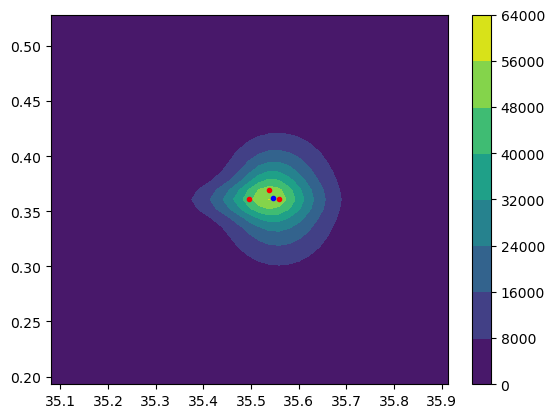

recall -- nb peaks: 3 peak detection: 2 bic: 2 aic: 2 dst: 4
dist -- nb peaks: 3 peak detection: 1 bic: 1 aic: 1 dst: 1


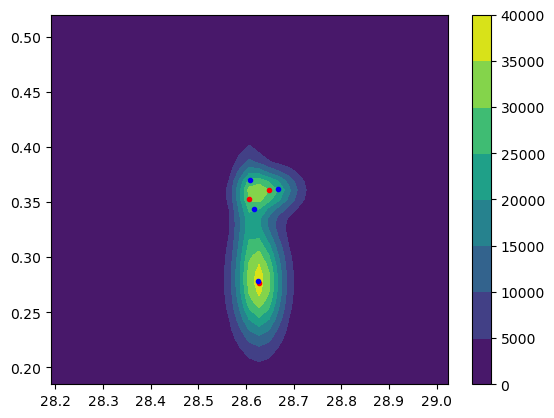

recall -- nb peaks: 2 peak detection: 2 bic: 2 aic: 2 dst: 4
dist -- nb peaks: 2 peak detection: 0 bic: 0 aic: 0 dst: 2


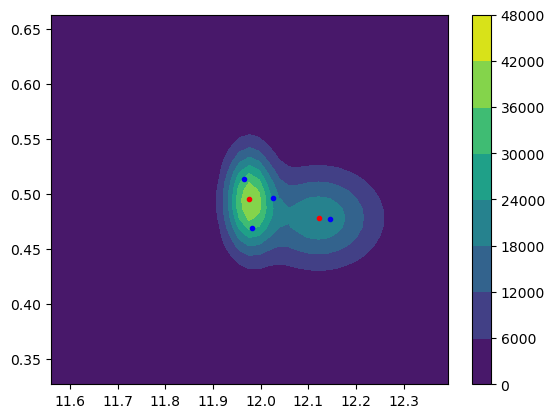

recall -- nb peaks: 3 peak detection: 2 bic: 2 aic: 2 dst: 4
dist -- nb peaks: 3 peak detection: 1 bic: 1 aic: 1 dst: 1


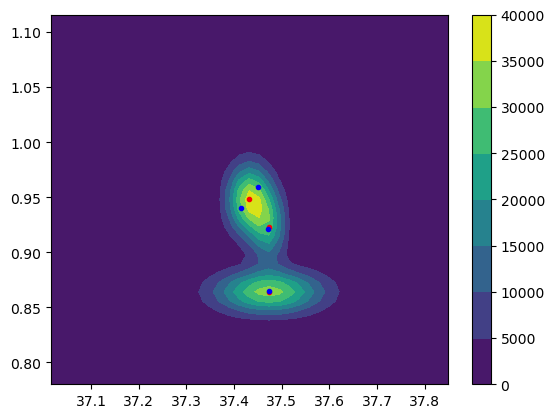

recall -- nb peaks: 1 peak detection: 1 bic: 1 aic: 3 dst: 1
dist -- nb peaks: 1 peak detection: 0 bic: 0 aic: 2 dst: 0


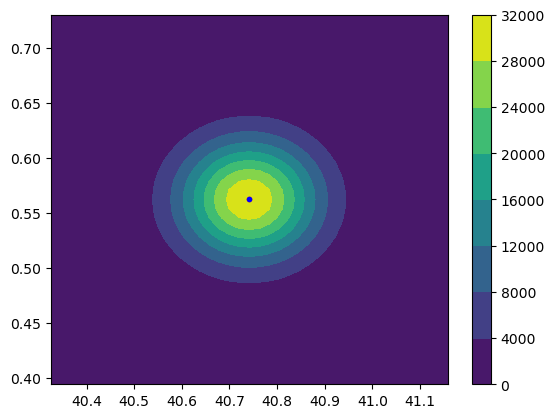

In [46]:
for i, chroma in enumerate(chromatos[:]):
    centers_in_chromato=projection.matrix_to_chromato(peaks_mu[i], time_rn, 1.25, chromato.shape)
    print("recall -- nb peaks: " + str(nbs_peak[i]) + " peak detection: " + str(peak_detection_recall[i]) + " bic: " + str(gm_bic_recall[i]) + " aic: " + str(gm_aic_recall[i]) + " dst: " + str(gm_dist_recall[i]))
    print("dist -- nb peaks: " + str(nbs_peak[i]) + " peak detection: " + str(peak_detection_recall_dist[i]) + " bic: " + str(gm_bic_recall_dist[i]) + " aic: " + str(gm_aic_recall_dist[i]) + " dst: " + str(gm_dist_recall_dist[i]))
    plot.visualizer(chromato_obj=(chroma, time_rn), log_chromato=False, contour=projection.matrix_to_chromato(np.array(gm_dist_cd[i]), time_rn, 1.25, chromato.shape), points=centers_in_chromato, center_pt=peaks_mu[i][0], center_pt_window_1=20,center_pt_window_2=20)
    

# Test Peak detection and suppression and detection

In [59]:
chromato_TIC_peak_suppr, chromato_cube_peak_suppr, params_peak_suppr=peak_simulation.create_chromato_cube(chromato.shape, 2, center_sigma=3.0, nb_mass=nb_mass, size=80)

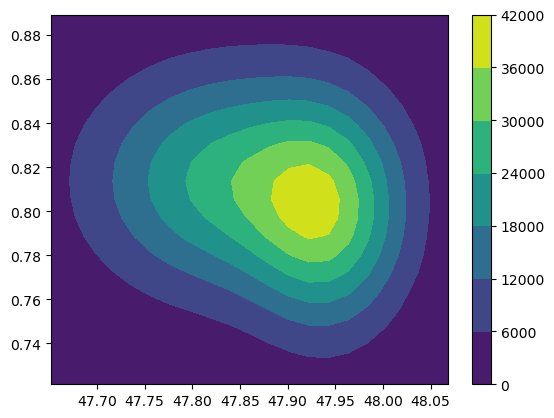

In [60]:
plot.visualizer((chromato_TIC_peak_suppr, time_rn), log_chromato=False, center_pt=params_peak_suppr['peaks_center'], center_pt_window_1=10, center_pt_window_2=10)

In [90]:
u, r = peak_detection.peak_detection(chromato_obj=(chromato_TIC_peak_suppr, time_rn, spectra_obj), spectra=None, chromato_cube=None, seuil=0.1, ABS_THRESHOLDS=None, method='DoG')
u_in_chromato=projection.matrix_to_chromato(u, time_rn, 1.25, chromato.shape)
u, u_in_chromato

ValueError: not enough values to unpack (expected 2, got 1)

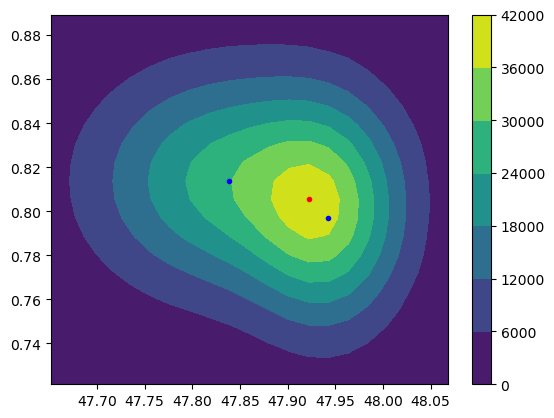

In [63]:
plot.visualizer((chromato_TIC_peak_suppr, time_rn), points=u_in_chromato, contour=projection.matrix_to_chromato(np.array(params_peak_suppr['peaks_mu']), time_rn, 1.25, chromato.shape), log_chromato=False, center_pt=params_peak_suppr['peaks_center'], center_pt_window_1=10, center_pt_window_2=10)

In [79]:
cds = np.array(integration.tmp(chromato_TIC_peak_suppr, u, u[0], threshold=0.3))

2D

In [121]:
gmm = GaussianMixture(n_components=1, tol=0.001)
gmm.fit(cds)
gaussian_peak_centers=np.around(gmm.means_,0).astype(int)

In [122]:
gaussian_peak_centers

array([[1892,   96]])

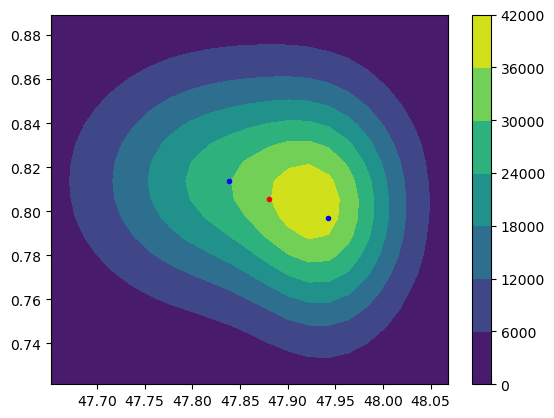

In [123]:
plot.visualizer((chromato_TIC_peak_suppr, time_rn), contour=projection.matrix_to_chromato(np.array(params_peak_suppr['peaks_mu']), time_rn, 1.25, chromato.shape), points=projection.matrix_to_chromato((gaussian_peak_centers), time_rn, 1.25, chromato.shape), log_chromato=False, center_pt=params_peak_suppr['peaks_center'], center_pt_window_1=10, center_pt_window_2=10)

3D

In [124]:
cds_3D=np.array([[cd[0], cd[1], chromato_TIC_peak_suppr[cd[0], cd[1]]] for cd in cds])

In [159]:
gmm = GaussianMixture(n_components=2, tol=0.001)
gmm.fit(cds_3D)
gaussian_peak_centers=np.around(gmm.means_,0).astype(int)

In [160]:
gaussian_peak_centers

array([[ 1894,    96, 21092],
       [ 1890,    96, 26496]])

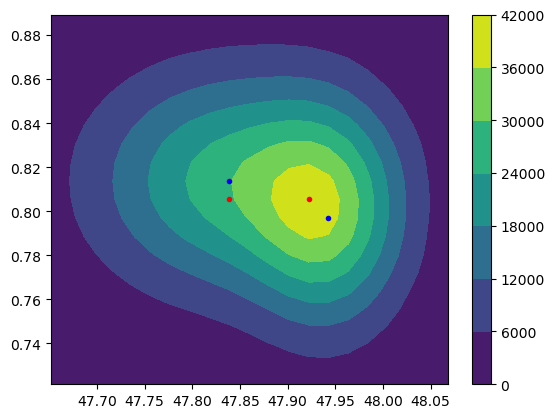

In [161]:
plot.visualizer((chromato_TIC_peak_suppr, time_rn), contour=projection.matrix_to_chromato(np.array(params_peak_suppr['peaks_mu']), time_rn, 1.25, chromato.shape), points=projection.matrix_to_chromato((gaussian_peak_centers), time_rn, 1.25, chromato.shape), log_chromato=False, center_pt=params_peak_suppr['peaks_center'], center_pt_window_1=10, center_pt_window_2=10)

jsp pas comment on peut estimer la gaussienne sous le pic pour le supprimer

# Test watershed

In [79]:
new_chromato_TIC, new_chromato_cube, params=peak_simulation.create_chromato_cube(chromato.shape, 3, center_sigma=3, nb_mass=nb_mass, size=80)

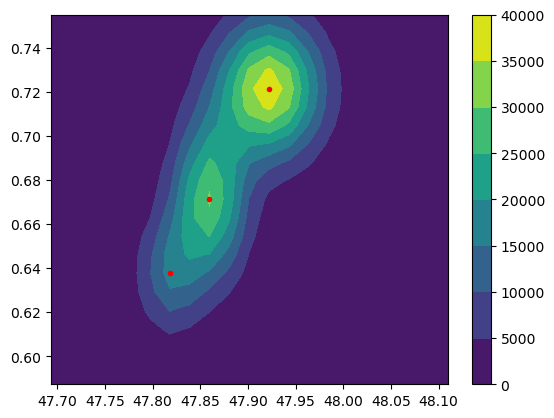

In [80]:
plot.visualizer((new_chromato_TIC, time_rn), log_chromato=False, center_pt=params['peaks_center'], center_pt_window_1=10, center_pt_window_2=10, points=projection.matrix_to_chromato(params['peaks_mu'], time_rn, 1.25, chromato.shape))

In [81]:
u = peak_detection.peak_detection(chromato_obj=(new_chromato_TIC, time_rn, spectra_obj), spectra=None, chromato_cube=None, seuil=0.1, ABS_THRESHOLDS=None, method='peak_local_max')
u_in_chromato=projection.matrix_to_chromato(u, time_rn, 1.25, chromato.shape)
u, u_in_chromato

(array([[1894,   86],
        [1891,   80]], dtype=int64),
 array([[47.92211224,  0.72147651],
        [47.85966962,  0.67114094]]))

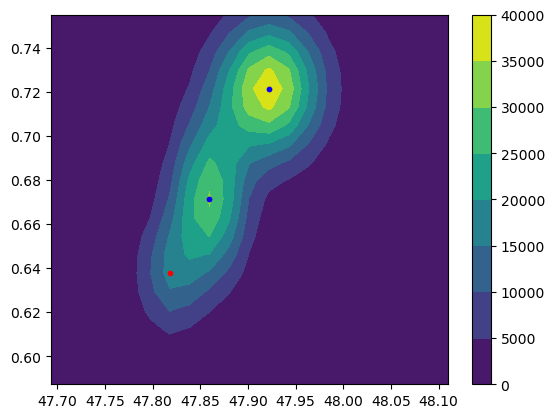

In [82]:
plot.visualizer((new_chromato_TIC, time_rn), log_chromato=False, center_pt=params['peaks_center'], contour=u_in_chromato, center_pt_window_1=10, center_pt_window_2=10, points=projection.matrix_to_chromato(params['peaks_mu'], time_rn, 1.25, chromato.shape))

In [85]:
cds = np.array(integration.tmp(new_chromato_TIC, u, u[1], threshold=0.3))

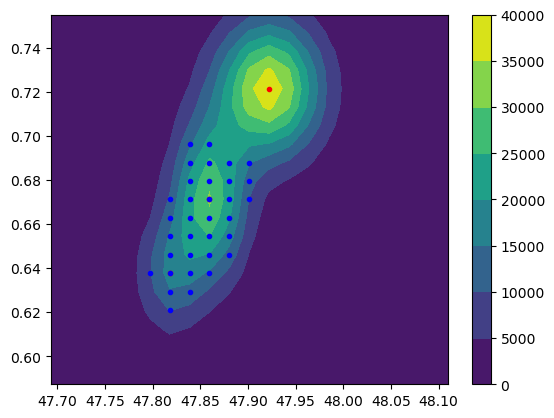

In [86]:
plot.visualizer((new_chromato_TIC, time_rn), log_chromato=False, center_pt=params['peaks_center'], contour=projection.matrix_to_chromato(cds, time_rn,1.25, chromato.shape), center_pt_window_1=10, center_pt_window_2=10, points=projection.matrix_to_chromato(params['peaks_mu'], time_rn, 1.25, chromato.shape))

In [87]:
cds = np.array(integration.tmp(new_chromato_TIC, u, u[0], threshold=0.3))

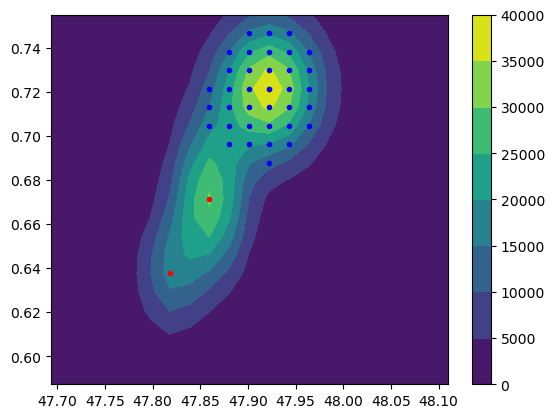

In [88]:
plot.visualizer((new_chromato_TIC, time_rn), log_chromato=False, center_pt=params['peaks_center'], contour=projection.matrix_to_chromato(cds, time_rn,1.25, chromato.shape), center_pt_window_1=10, center_pt_window_2=10, points=projection.matrix_to_chromato(params['peaks_mu'], time_rn, 1.25, chromato.shape))

In [123]:
peaks_dist=[]
gm_dist_cd=[]
peaks_bic=[]
gm_bic_cd=[]

all_cds=[]
for k in range(len(u)):
    cds = np.array(integration.tmp(new_chromato_TIC, u, u[k], threshold=0.3))     
    centers_dist, nb_components_dist=integration.estimate_peaks_center_with_dist(cds, new_chromato_cube, mass_values, num_components=None)
    centers_bic, nb_components_bic=integration.estimate_peaks_center_bic(cds, num_components=None)
    peaks_dist.append(centers_dist)
    peaks_bic.append(centers_bic)
    all_cds.append(cds)

peaks_dist=np.concatenate(peaks_dist)
peaks_bic=np.concatenate(peaks_bic)

gm_dist_cd.append(peaks_dist)
gm_dist_cd=np.array(gm_dist_cd)

gm_bic_cd.append(peaks_bic)
gm_bic_cd=np.array(gm_bic_cd)


[1893   84] [1894   87]
2023-05-31 11:03:34,239:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-05-31 11:03:34,241:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
4
[1895   85] [1894   88]
2023-05-31 11:03:34,253:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-05-31 11:03:34,254:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
[1895   85] [1892   85]
2023-05-31 11:03:34,256:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-05-31 11:03:34,257:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
[1894   88] [1892   85]
2023-05-31 11:03:34,259:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-05-31 11:03:34,260:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
4
[1.0, 0.9963484373208751, 0.9898671480121282]
[297.79985038383666, 315.67413139931284, 331.5506301834489]
[1891   81] [1890   77]
2023-05-31 11:03:34,331:WARNING:ma

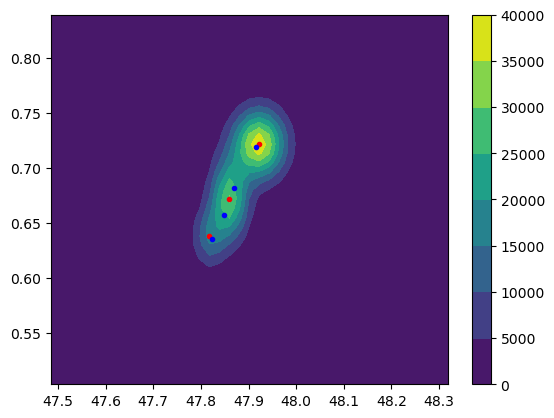

In [124]:
plot.visualizer(chromato_obj=(new_chromato_TIC, time_rn), log_chromato=False , contour=projection.matrix_to_chromato(gm_dist_cd[0], time_rn, 1.25, chromato.shape), points=projection.matrix_to_chromato(params['peaks_mu'], time_rn, 1.25, chromato.shape), center_pt=params['peaks_center'], center_pt_window_1=20,center_pt_window_2=20)


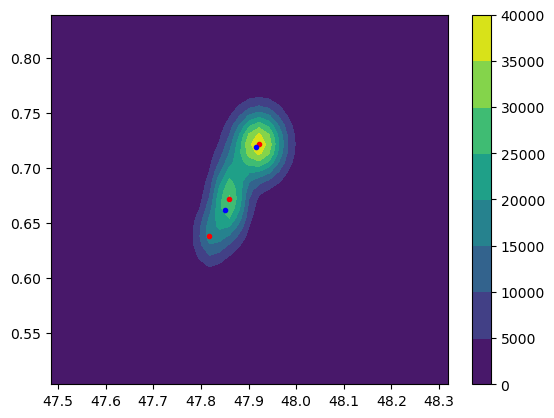

In [125]:
plot.visualizer(chromato_obj=(new_chromato_TIC, time_rn), log_chromato=False , contour=projection.matrix_to_chromato(gm_bic_cd[0], time_rn, 1.25, chromato.shape), points=projection.matrix_to_chromato(params['peaks_mu'], time_rn, 1.25, chromato.shape), center_pt=params['peaks_center'], center_pt_window_1=20,center_pt_window_2=20)


Peut être qu'en faisant Gaussian Mixture sur la forme on aurait un meilleur résultat

In [126]:
all_cds=np.concatenate(all_cds)

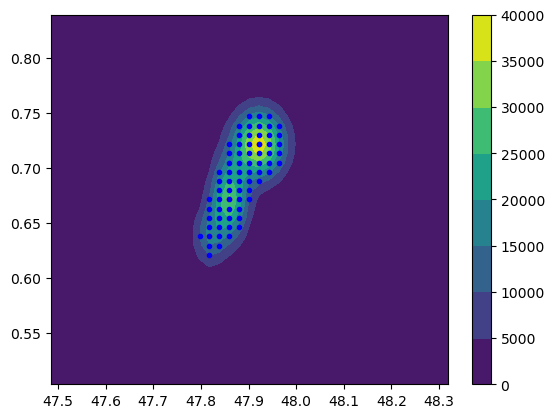

In [127]:
plot.visualizer(chromato_obj=(new_chromato_TIC, time_rn), log_chromato=False , contour=projection.matrix_to_chromato(all_cds, time_rn, 1.25, chromato.shape), points=projection.matrix_to_chromato(params['peaks_mu'], time_rn, 1.25, chromato.shape), center_pt=params['peaks_center'], center_pt_window_1=20,center_pt_window_2=20)


In [105]:
centers_dist, nb_components_dist=integration.estimate_peaks_center_with_dist(all_cds, new_chromato_cube, mass_values, num_components=None, max_components=4)

[1891   79] [1894   85]
2023-05-31 10:50:01,248:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-05-31 10:50:01,250:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
3
[1890   78] [1894   86]
2023-05-31 10:50:01,265:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-05-31 10:50:01,266:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
[1890   78] [1892   83]
2023-05-31 10:50:01,269:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-05-31 10:50:01,270:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
[1894   86] [1892   83]
2023-05-31 10:50:01,272:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-05-31 10:50:01,273:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
5
[1894   87] [1891   80]
2023-05-31 10:50:01,287:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-05-31 10:50:01,289:WARNING:matchms:add_prec

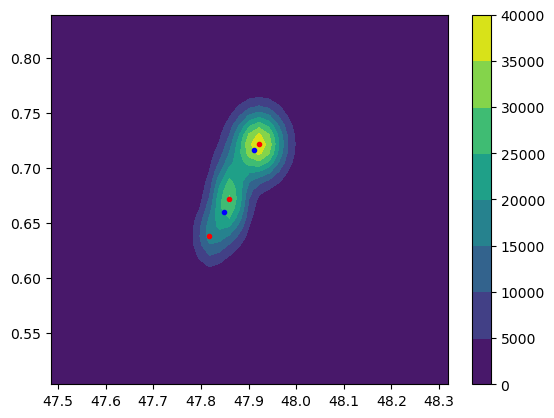

In [117]:
plot.visualizer(chromato_obj=(new_chromato_TIC, time_rn), log_chromato=False , contour=projection.matrix_to_chromato(np.array(centers_dist), time_rn, 1.25, chromato.shape), points=projection.matrix_to_chromato(params['peaks_mu'], time_rn, 1.25, chromato.shape), center_pt=params['peaks_center'], center_pt_window_1=20,center_pt_window_2=20)

In [130]:
importlib.reload(integration)

<module 'integration' from 'c:\\Users\\33631\\Desktop\\stage\\pic\\integration.py'>

In [132]:
centers_dist, nb_components_dist=integration.estimate_peaks_center_bic(all_cds, num_components=None, max_components=4)

[665.5323751693109, 677.0026567535144, 699.8928363627483, 723.1763051829554]


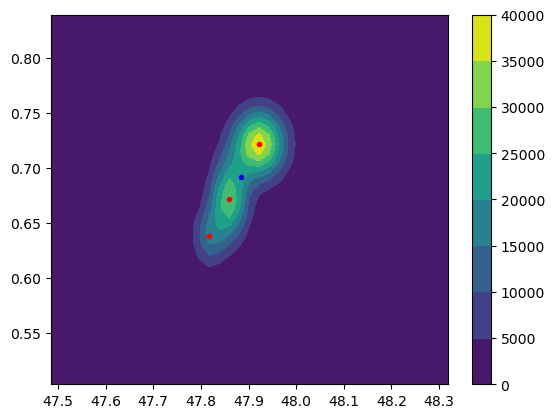

In [133]:
plot.visualizer(chromato_obj=(new_chromato_TIC, time_rn), log_chromato=False , contour=projection.matrix_to_chromato(np.array(centers_dist), time_rn, 1.25, chromato.shape), points=projection.matrix_to_chromato(params['peaks_mu'], time_rn, 1.25, chromato.shape), center_pt=params['peaks_center'], center_pt_window_1=20,center_pt_window_2=20)

Pas top dans les deux cas

# Test hmdb

In [112]:
from matchms.importing import load_from_mgf, scores_from_json
from matchms import calculate_scores
from matchms.similarity import CosineGreedy

In [142]:
spectra = list(load_from_mgf("./lib_EIB.mgf"))[:100]

2023-06-01 11:48:26,455:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-06-01 11:48:26,464:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-06-01 11:48:26,467:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-06-01 11:48:26,470:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-06-01 11:48:26,472:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-06-01 11:48:26,474:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-06-01 11:48:26,477:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-06-01 11:48:26,480:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-06-01 11:48:26,482:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-06-01 11:48:26,484:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-06-01 11:48:26,487:WARNING:matchms:add_precursor_mz:No precursor_mz found i

In [278]:
scores = calculate_scores(references=spectra,
                          queries=spectra,
                          similarity_function=CosineGreedy(),
                          is_symmetric=False, array_type="numpy")

In [179]:
scores.to_json('./lib_scores.json')

In [180]:
d=scores_from_json('./lib_scores.json')

In [299]:
arr=scores.scores.to_array()['CosineGreedy_score']

# Test I variation

In [28]:
importlib.reload(peak_simulation)
new_chromato_TIC, new_chromato_cube, params=peak_simulation.create_chromato_cube(chromato.shape, 3, mu_center=[], center_dist=3, size=80)
print(params['peaks_mu'])

spectrum shape:  24
15 389
cube shape:  (2187, 150, 375)


c:\Users\33631\Desktop\stage\pic\peak_simulation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spectra=np.array(spectra)


[[2009, 70], [2011, 68]]


In [36]:
params

{'peaks_mu': [[2009, 70], [2011, 68]],
 'peaks_sigma': [(4.995743864978019, 4.601301048348439),
  (4.995743864978019, 4.601301048348439)],
 'spectra_id': ['HMDB0000067', 'HMDB0000039'],
 'peaks_center': [2012, 70],
 'center_dist': 3,
 'range': (15, 389)}

In [39]:
ion1=386
ion2=60

In [29]:
new_chromato_cube_noisy=peak_simulation.add_noise_3D('gauss',new_chromato_cube)

In [30]:
peaks_mu_in_chromato=projection.matrix_to_chromato(np.array(params['peaks_mu']), time_rn, 1.25, chromato.shape)
peaks_center_in_chromato=projection.matrix_to_chromato(np.array([params['peaks_center']]), time_rn, 1.25, chromato.shape)

In [31]:
u = peak_detection.peak_detection(chromato_obj=(new_chromato_TIC, time_rn, spectra_obj), spectra=None, chromato_cube=None, seuil=0.1, ABS_THRESHOLDS=None, method='peak_local_max')
u_in_chromato=projection.matrix_to_chromato(u, time_rn, 1.25, chromato.shape)
u, u_in_chromato

(array([[2010,   69]], dtype=int64), array([[50.33656051,  0.57885906]]))

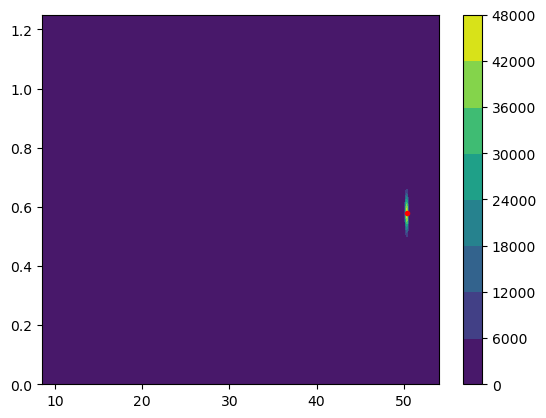

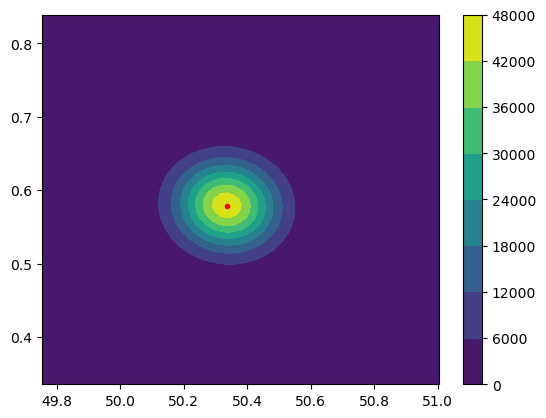

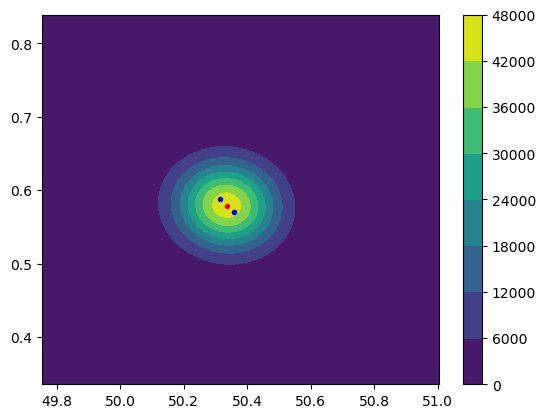

In [32]:
plot.visualizer(chromato_obj=(new_chromato_TIC,time_rn), log_chromato=False, points=u_in_chromato)
plot.visualizer(chromato_obj=(new_chromato_TIC, time_rn), log_chromato=False, points=u_in_chromato,center_pt=params['peaks_center'], center_pt_window_1=30,center_pt_window_2=30)
plot.visualizer(chromato_obj=(new_chromato_TIC, time_rn), log_chromato=False, contour=peaks_mu_in_chromato, points=u_in_chromato, center_pt=params['peaks_center'], center_pt_window_1=30,center_pt_window_2=30)

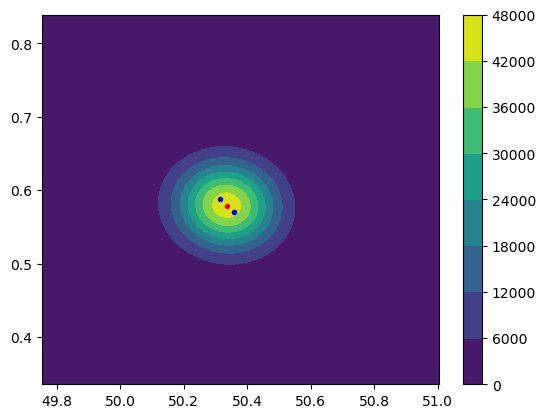

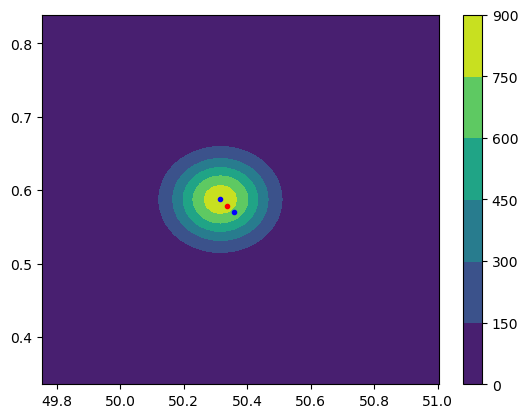

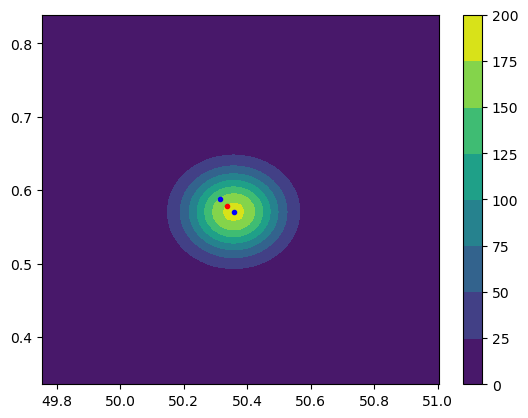

In [40]:
plot.visualizer(chromato_obj=(new_chromato_TIC, time_rn), log_chromato=False, contour=peaks_mu_in_chromato, points=u_in_chromato, center_pt=params['peaks_center'], center_pt_window_1=30,center_pt_window_2=30)
plot.visualizer(chromato_obj=(new_chromato_cube[ion1 - params['range'][0] + 1], time_rn), log_chromato=False, contour=peaks_mu_in_chromato, points=u_in_chromato, center_pt=params['peaks_center'], center_pt_window_1=30,center_pt_window_2=30)
plot.visualizer(chromato_obj=(new_chromato_cube[ion2 - params['range'][0] + 1], time_rn), log_chromato=False, contour=peaks_mu_in_chromato, points=u_in_chromato, center_pt=params['peaks_center'], center_pt_window_1=30,center_pt_window_2=30)

In [42]:
u3d = peak_detection.peak_detection(chromato_obj=(new_chromato_TIC, time_rn, spectra_obj), spectra=None, chromato_cube=new_chromato_cube_noisy, seuil=0.1, ABS_THRESHOLDS=0.1, method='peak_local_max', mode='3D', cluster=False)
u_in_chromato_3d=projection.matrix_to_chromato(u3d, time_rn, 1.25, chromato.shape)
u3d, u_in_chromato_3d

(array([[2009,   70],
        [2010,   69],
        [2011,   68]], dtype=int64),
 array([[50.3157463 ,  0.58724832],
        [50.33656051,  0.57885906],
        [50.35737472,  0.5704698 ]]))

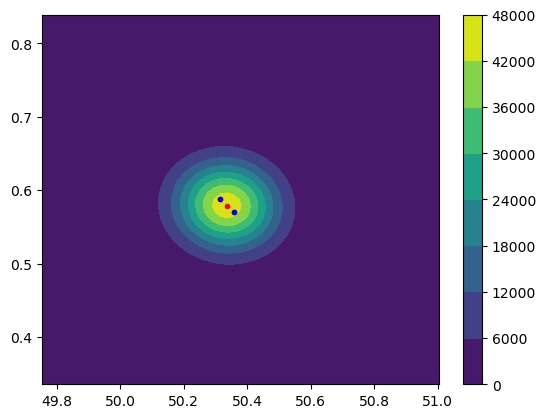

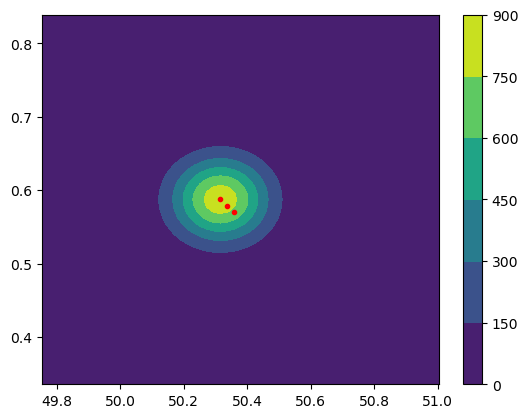

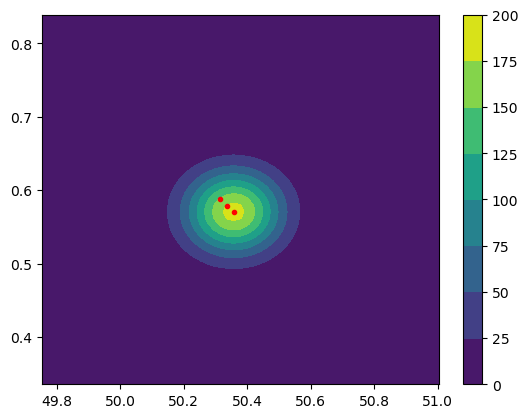

In [43]:
plot.visualizer(chromato_obj=(new_chromato_TIC, time_rn), log_chromato=False, contour=peaks_mu_in_chromato, points=u_in_chromato_3d, center_pt=params['peaks_center'], center_pt_window_1=30,center_pt_window_2=30)
plot.visualizer(chromato_obj=(new_chromato_cube[ion1 - params['range'][0] + 1], time_rn), log_chromato=False, points=u_in_chromato_3d, center_pt=params['peaks_center'], center_pt_window_1=30,center_pt_window_2=30)
plot.visualizer(chromato_obj=(new_chromato_cube[ion2 - params['range'][0] + 1], time_rn), log_chromato=False, points=u_in_chromato_3d, center_pt=params['peaks_center'], center_pt_window_1=30,center_pt_window_2=30)

In [44]:
from sklearn.decomposition import PCA
# X représente les données spectrales superposées (chaque ligne représente un spectre)
# Effectue l'ACP en réduisant la dimension à k composantes principales
def perform_pca(X, k):
    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X)
    return X_pca,pca

In [45]:
def tmp(chromato, coordinates, coordinate, threshold=0.25):
    mask = np.zeros(chromato.shape, dtype=bool)
    mask[tuple(coordinates.T)] = True
    markers, _ = ndi.label(mask)
    peak_apex_int = chromato[coordinate[0]][coordinate[1]]
    img = np.where(chromato < threshold * peak_apex_int, 0, 1)
    labels = watershed(-chromato, markers, mask=img)
    coordinate_label = labels[coordinate[0]][coordinate[1]]
    blob = np.where(labels != coordinate_label, 0, 1)
    cds = []
    for cd in np.argwhere(blob == 1):
        cds.append([cd[0], cd[1]])
    return cds

In [46]:
def compute_spectra_array(cds, chromato_cube):
    spc=[]
    for i,cd in enumerate(cds):
        spc.append(mass_spec.read_spectrum_from_chromato_cube(cd, chromato_cube=chromato_cube))
    return np.array(spc)

In [47]:
#search zone
cds = np.array(tmp(new_chromato_TIC, u, u[0], threshold=0.3))
#spectra in search zone
spc=compute_spectra_array(cds, new_chromato_cube)
cds.shape, spc.shape

((181, 2), (181, 375))

In [48]:
# Exemple d'utilisation
#X_superpose = intensity_center
k = 2  # Nombre de composantes principales à extraire
X_pca,pca= perform_pca(spc, k)

In [49]:
pca.explained_variance_ratio_

array([0.86301338, 0.13698662])

In [78]:
np.argmin(np.abs(X_pca[:,0]))

50

In [69]:
np.argmin(X_pca[:,0]), np.argmax(X_pca[:,0])

(16, 104)

In [70]:
cds[np.argmin(X_pca[:,0])], cds[np.argmax(X_pca[:,0])], 

(array([2004,   74], dtype=int64), array([2011,   68], dtype=int64))

In [79]:
cds[np.argmin(np.abs(X_pca[:,0]))]

array([2007,   72], dtype=int64)

In [71]:
params

{'peaks_mu': [[2009, 70], [2011, 68]],
 'peaks_sigma': [(4.995743864978019, 4.601301048348439),
  (4.995743864978019, 4.601301048348439)],
 'spectra_id': ['HMDB0000067', 'HMDB0000039'],
 'peaks_center': [2012, 70],
 'center_dist': 3,
 'range': (15, 389)}

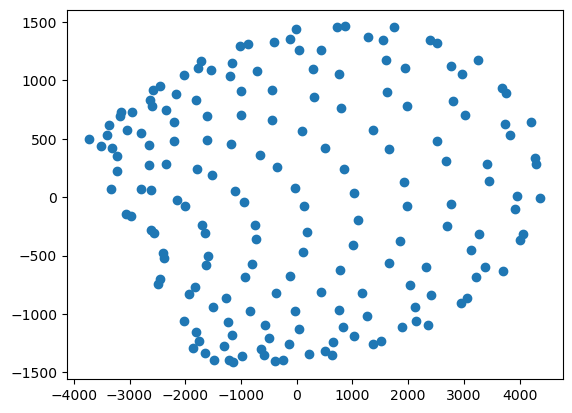

In [50]:
plt.scatter(X_pca[:,0], X_pca[:,1])

In [52]:
n_pcs= pca.components_.shape[0]
most_important = [np.argsort(np.abs(pca.components_[i]))[-10:] for i in range(n_pcs)]

In [60]:
most_important[0]+=params['range'][0]
most_important[1]+=params['range'][0]

In [61]:
most_important

[array([ 29,  45,  55,  42,  41, 386,  27,  43,  73,  60], dtype=int64),
 array([368,  57, 387,  95,  55,  81, 388,  44,  60, 386], dtype=int64)]

In [83]:
ion1, ion2, params

(386,
 60,
 {'peaks_mu': [[2009, 70], [2011, 68]],
  'peaks_sigma': [(4.995743864978019, 4.601301048348439),
   (4.995743864978019, 4.601301048348439)],
  'spectra_id': ['HMDB0000067', 'HMDB0000039'],
  'peaks_center': [2012, 70],
  'center_dist': 3,
  'range': (15, 389)})

In [84]:
cd=[]
for ion in most_important[0]:
    u = peak_detection.peak_detection(chromato_obj=(new_chromato_cube_noisy[ion - params['range'][0]], time_rn, spectra_obj), spectra=None, chromato_cube=None, seuil=0.1, ABS_THRESHOLDS=None, method='peak_local_max')
    cd.append(u)


In [85]:
cd

[array([[2011,   68]], dtype=int64),
 array([[2011,   68]], dtype=int64),
 array([[2010,   69]], dtype=int64),
 array([[2011,   68]], dtype=int64),
 array([[2011,   68]], dtype=int64),
 array([[2009,   70]], dtype=int64),
 array([[2011,   68]], dtype=int64),
 array([[2010,   69]], dtype=int64),
 array([[2011,   68]], dtype=int64),
 array([[2011,   68]], dtype=int64)]

In [91]:
np.min(cds[:,0], axis=0), np.max(cds[:,0], axis=0), np.min(cds[:,1], axis=0), np.max(cds[:,1], axis=0)

(2003, 2017, 62, 76)

In [88]:
import tensorly.decomposition as dec

In [99]:
chromato.shape

(2187, 150)

In [98]:
new_chromato_cube.shape

(375, 2187, 150)

In [102]:
chromato_parafac=np.moveaxis(new_chromato_cube, 0, -1)
chromato_parafac.shape

(2187, 150, 375)

In [106]:
np.min(cds[:,0], axis=0), np.max(cds[:,0], axis=0), np.min(cds[:,1], axis=0), np.max(cds[:,1], axis=0)

(2003, 2017, 62, 76)

In [108]:
ttttttttttt=dec.parafac(chromato_parafac[np.min(cds[:,0], axis=0): np.max(cds[:,0], axis=0), np.min(cds[:,1], axis=0): np.max(cds[:,1], axis=0)], rank=3)

# Refacto peak simulation

In [200]:
chrom=np.ones_like(chromato)
mu1=[chrom.shape[0]//2,chrom.shape[1]//2]
mu2=[chrom.shape[0]//2+10,chrom.shape[1]//2+5]
points=np.array([mu1, mu2])
points_in_chromato=projection.matrix_to_chromato(points, time_rn, 1.25, chromato.shape)
sigma1=(5.0, 2.5)
sigma2=(5.0, 2.5)
blob1=np.array([mu1[0], mu1[1], sigma1[0], sigma1[1]])
blob2=np.array([mu2[0], mu2[1], sigma2[0], sigma2[1]])
blobs=np.array([blob1, blob2])
points_radius=blobs[...,2]
chrom=peak_simulation.create_and_add_peak(chrom, 40, 20000, mu1, sigma1)
chrom=peak_simulation.create_and_add_peak(chrom, 40, 20000, mu2, sigma2)

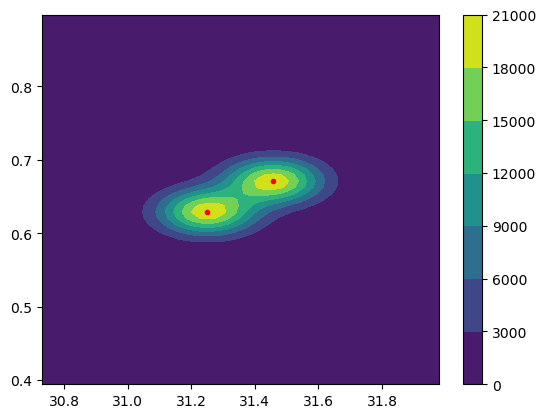

In [201]:
plot.visualizer((chrom, time_rn), center_pt=(np.array(mu1) + np.array(mu2)) // 2, center_pt_window_1=30, center_pt_window_2=30, points=points_in_chromato, log_chromato=False)

In [202]:
peak_simulation._blob_overlap(blob1, blob2, sigma_dim=len(sigma1))

[1093.   75.]
[5.  2.5] 1.4142135623730951
[7.07106781 3.53553391]


0.0

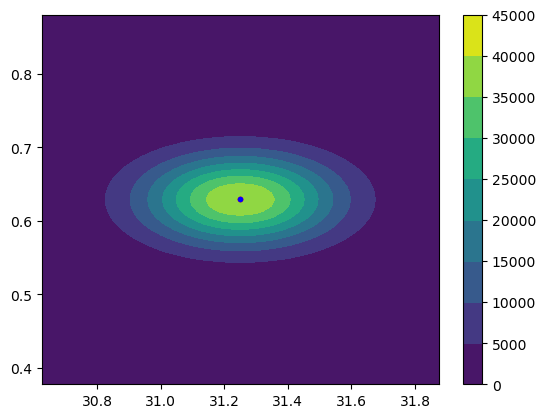

dist:  0 nb peak:  1


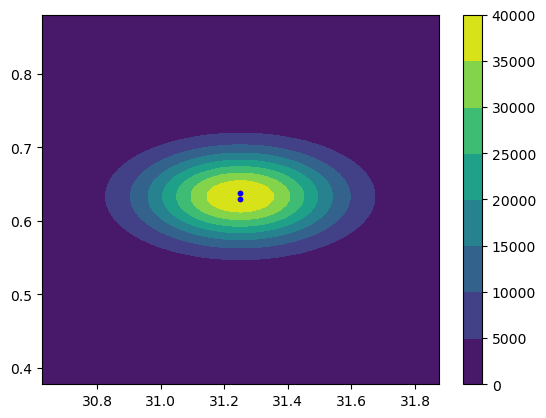

dist:  1 nb peak:  2


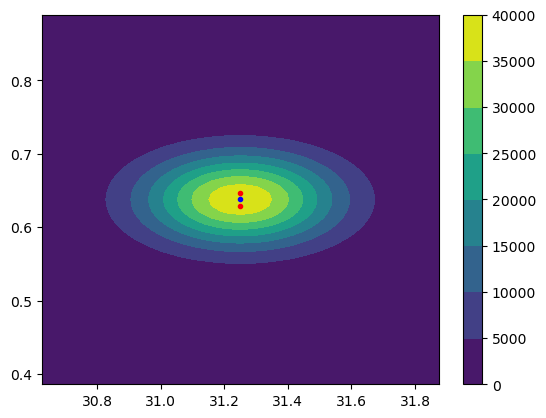

dist:  2 nb peak:  1


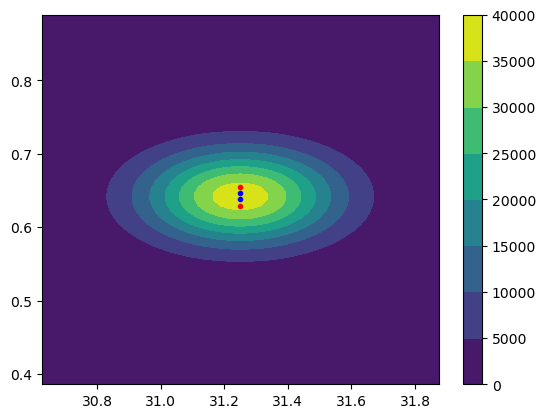

dist:  3 nb peak:  2


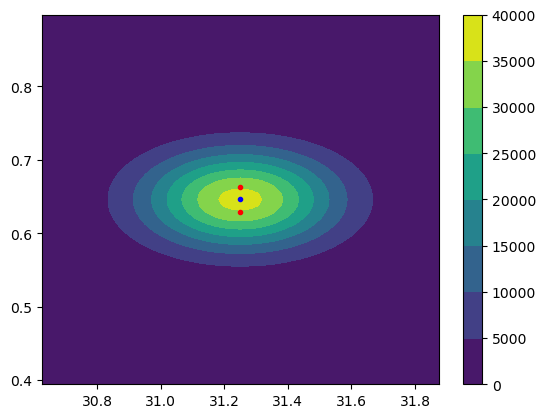

dist:  4 nb peak:  1


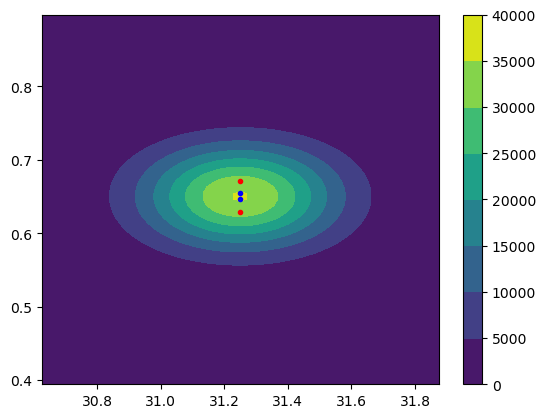

dist:  5 nb peak:  2


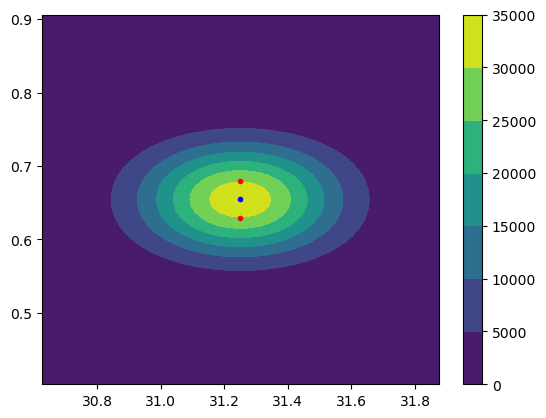

dist:  6 nb peak:  1


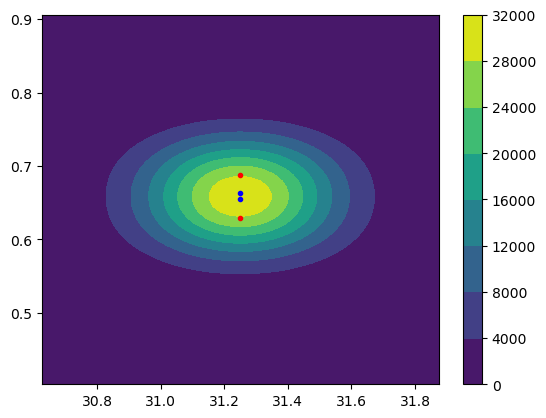

dist:  7 nb peak:  2


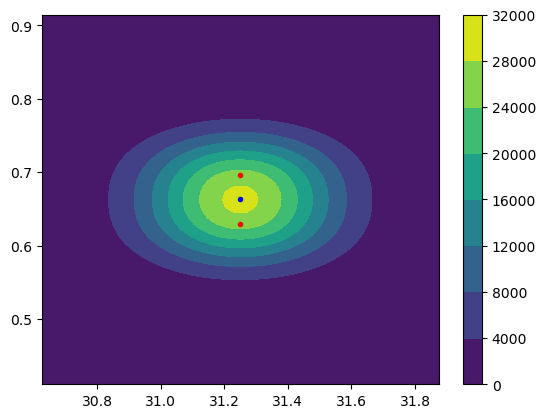

dist:  8 nb peak:  1


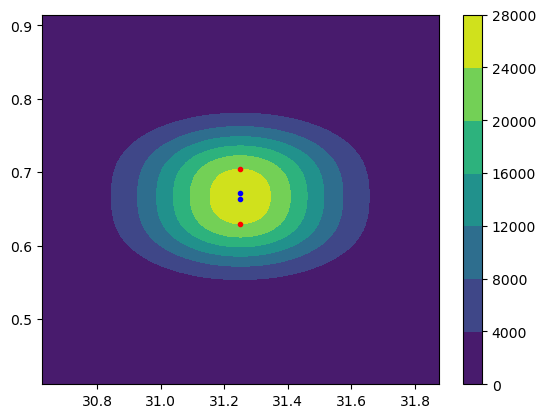

dist:  9 nb peak:  2


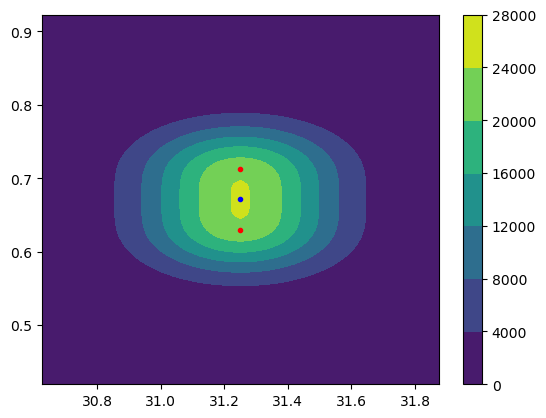

dist:  10 nb peak:  1


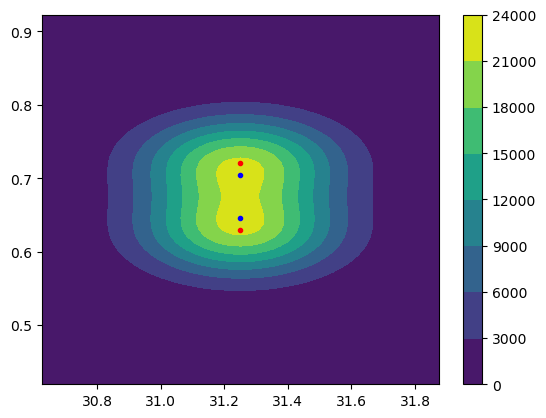

dist:  11 nb peak:  2


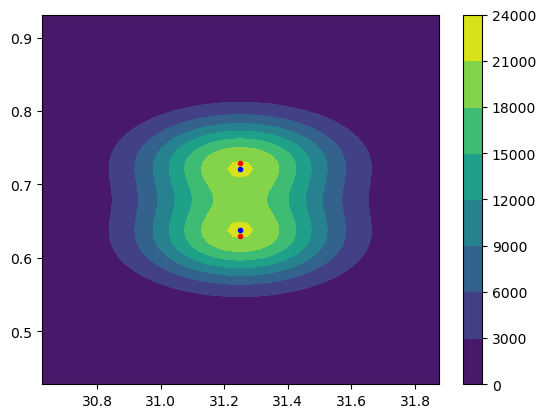

dist:  12 nb peak:  2


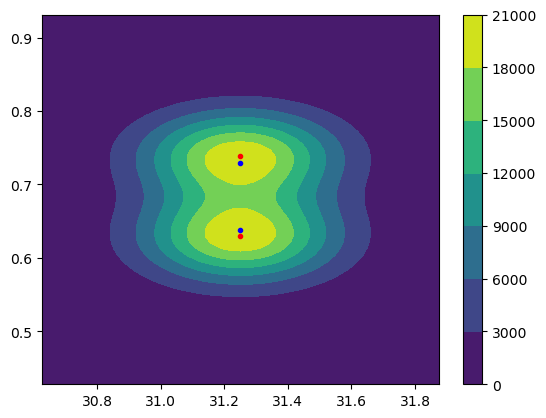

dist:  13 nb peak:  2


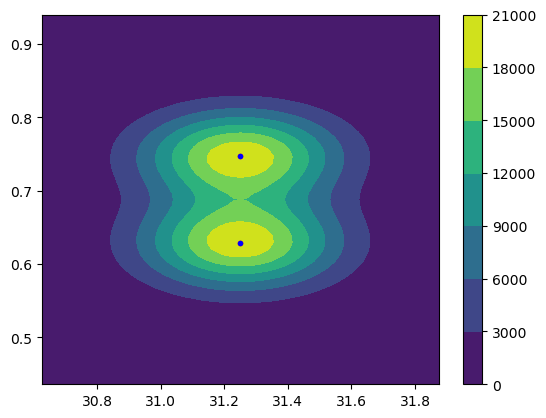

dist:  14 nb peak:  2


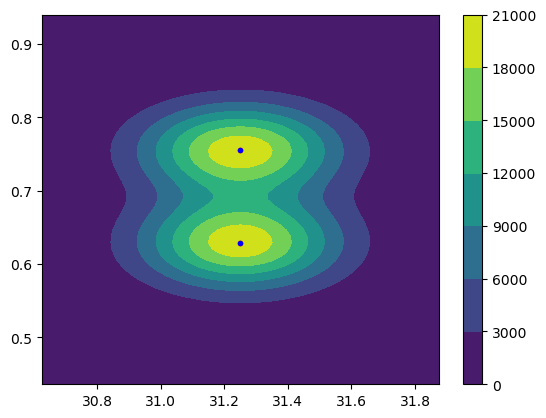

dist:  15 nb peak:  2


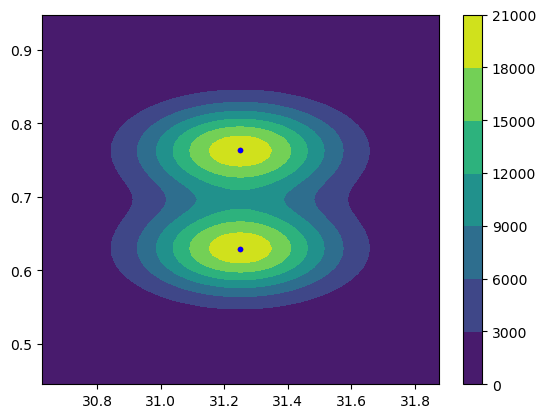

dist:  16 nb peak:  2


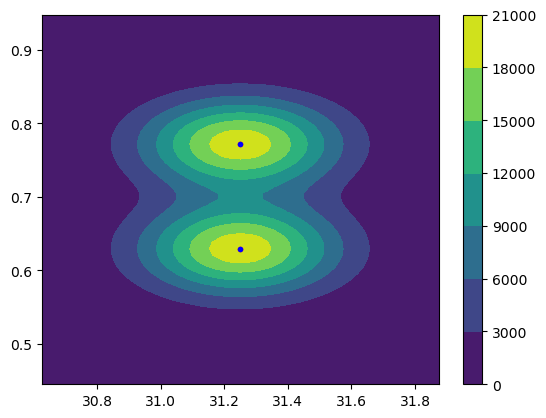

dist:  17 nb peak:  2


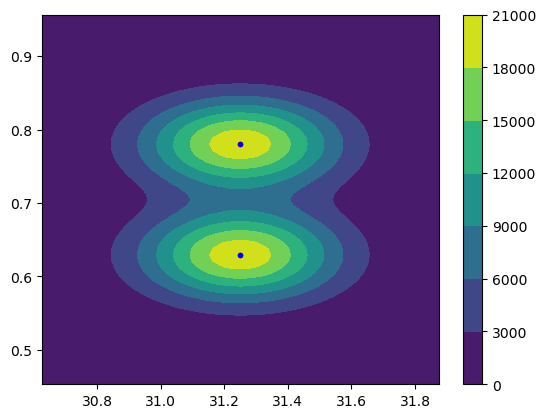

dist:  18 nb peak:  2


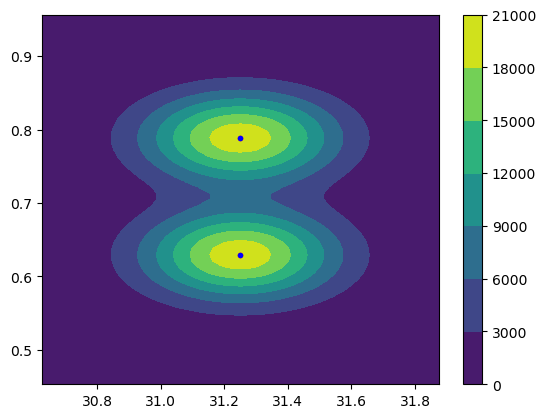

dist:  19 nb peak:  2


In [236]:
from skimage.feature import peak_local_max
def compute_metrics(shape, show=False):
    dist=[]
    nb_peaks=[]
    overlaps=[]
    for i in range (0, 20):
        chrom=np.ones(shape)
        mu1=[chrom.shape[0]//2,chrom.shape[1]//2]
        mu2=[chrom.shape[0]//2,chrom.shape[1]//2+i]
        points=np.array([mu1, mu2])
        points_in_chromato=projection.matrix_to_chromato(points, time_rn, 1.25, shape)
        sigma1=(10.0, 5.0)
        sigma2=(10.0, 5.0)
        blob1=np.array([mu1[0], mu1[1], sigma1[0], sigma1[1]])
        blob2=np.array([mu2[0], mu2[1], sigma2[0], sigma2[1]])
        blobs=np.array([blob1, blob2])
        points_radius=blobs[...,2]
        chrom=peak_simulation.create_and_add_peak(chrom, 40, 20000, mu1, sigma1)
        chrom=peak_simulation.create_and_add_peak(chrom, 40, 20000, mu2, sigma2)
        u=peak_local_max(chrom)
        u_in_chromato=projection.matrix_to_chromato(u, time_rn, 1.25, shape)
        dist.append(i)
        nb_peaks.append(len(u))
        overlaps.append(peak_simulation._blob_overlap(blob1, blob2, sigma_dim=len(sigma1)))
        if (show):
            plot.visualizer((chrom, time_rn), center_pt=(np.array(mu1) + np.array(mu2)) // 2, center_pt_window_1=30, center_pt_window_2=30, contour=u_in_chromato , points=points_in_chromato, log_chromato=False)
            print("dist: ", i, "nb peak: ", len(u))
    return dist, nb_peaks, overlaps
dist, nb_peaks, overlaps=compute_metrics(chromato.shape, True)

In [246]:
len(dist), len(nb_peaks), len(dist), len(overlaps)

(20, 20, 20, 20)

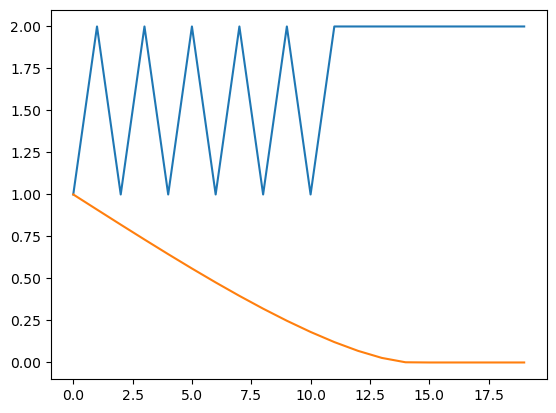

In [251]:
plt.plot(dist, nb_peaks)
plt.plot(dist, overlaps)

In [308]:
chrom, chromato_clusters=peak_simulation.create_chromato_with_overlapped_cluster(chromato.shape)

1/106 1/4
1/106 2/4
1/106 3/4
1/106 4/4
2/106 1/4
2/106 2/4
2/106 3/4
2/106 4/4
3/106 1/4
3/106 2/4
3/106 3/4
3/106 4/4
4/106 1/4
4/106 2/4
4/106 3/4
4/106 4/4
5/106 1/4
5/106 2/4
5/106 3/4
5/106 4/4
6/106 1/4
6/106 2/4
6/106 3/4
6/106 4/4
7/106 1/4
7/106 2/4
7/106 3/4
7/106 4/4
8/106 1/4
8/106 2/4
8/106 3/4
8/106 4/4
9/106 1/4
9/106 2/4
9/106 3/4
9/106 4/4
10/106 1/4
10/106 2/4
10/106 3/4
10/106 4/4
11/106 1/4
11/106 2/4
11/106 3/4
11/106 4/4
12/106 1/4
12/106 2/4
12/106 3/4
12/106 4/4
13/106 1/4
13/106 2/4
13/106 3/4
13/106 4/4
14/106 1/4
14/106 2/4
14/106 3/4
14/106 4/4
15/106 1/4
15/106 2/4
15/106 3/4
15/106 4/4
16/106 1/4
16/106 2/4
16/106 3/4
16/106 4/4
17/106 1/4
17/106 2/4
17/106 3/4
17/106 4/4
18/106 1/4
18/106 2/4
18/106 3/4
18/106 4/4
19/106 1/4
19/106 2/4
19/106 3/4
19/106 4/4
20/106 1/4
20/106 2/4
20/106 3/4
20/106 4/4
21/106 1/4
21/106 2/4
21/106 3/4
21/106 4/4
22/106 1/4
22/106 2/4
22/106 3/4
22/106 4/4
23/106 1/4
23/106 2/4
23/106 3/4
23/106 4/4
24/106 1/4
24/106 2/4
24

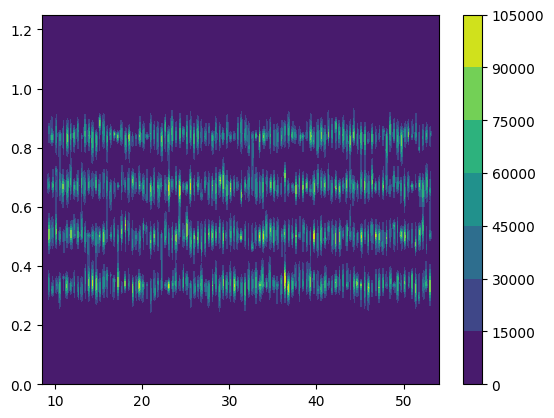

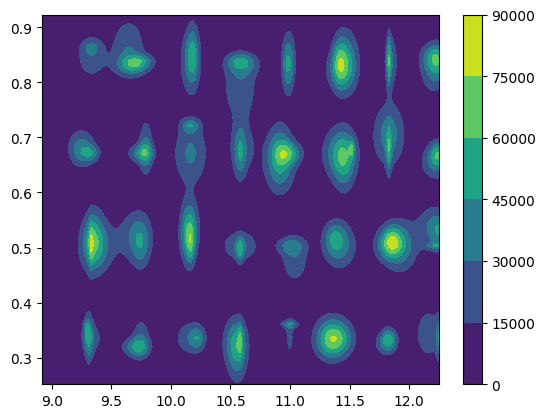

In [309]:
plot.visualizer((chrom, time_rn),  log_chromato=False)
plot.visualizer((chrom, time_rn), center_pt=[100, 70], center_pt_window_1=80, center_pt_window_2=40, log_chromato=False)

In [312]:
importlib.reload(peak_simulation)
chromato_TIC, chromato_cube=peak_simulation.create_chromato_cube_with_overlapped_cluster(chromato.shape)

1/106 1/4
1/106 2/4
1/106 3/4
1/106 4/4
2/106 1/4
2/106 2/4
2/106 3/4
2/106 4/4
3/106 1/4
3/106 2/4
3/106 3/4
3/106 4/4
4/106 1/4
4/106 2/4
4/106 3/4
4/106 4/4
5/106 1/4
5/106 2/4
5/106 3/4
5/106 4/4
6/106 1/4
6/106 2/4
6/106 3/4
6/106 4/4
7/106 1/4
7/106 2/4
7/106 3/4
7/106 4/4
8/106 1/4
8/106 2/4
8/106 3/4
8/106 4/4
9/106 1/4
9/106 2/4
9/106 3/4
9/106 4/4
10/106 1/4
10/106 2/4
10/106 3/4
10/106 4/4
11/106 1/4
11/106 2/4
11/106 3/4
11/106 4/4
12/106 1/4
12/106 2/4
12/106 3/4
12/106 4/4
13/106 1/4
13/106 2/4
13/106 3/4
13/106 4/4
14/106 1/4
14/106 2/4
14/106 3/4
14/106 4/4
15/106 1/4
15/106 2/4
15/106 3/4
15/106 4/4
16/106 1/4
16/106 2/4
16/106 3/4
16/106 4/4
17/106 1/4
17/106 2/4
17/106 3/4
17/106 4/4
18/106 1/4
18/106 2/4
18/106 3/4
18/106 4/4
19/106 1/4
19/106 2/4
19/106 3/4
19/106 4/4
20/106 1/4
20/106 2/4
20/106 3/4
20/106 4/4
21/106 1/4
21/106 2/4
21/106 3/4
21/106 4/4
22/106 1/4
22/106 2/4
22/106 3/4
22/106 4/4
23/106 1/4
23/106 2/4
23/106 3/4
23/106 4/4
24/106 1/4
24/106 2/4
24

c:\Users\33631\Desktop\stage\pic\peak_simulation.py:767: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
c:\Users\33631\Desktop\stage\pic\peak_simulation.py:769: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


12 499


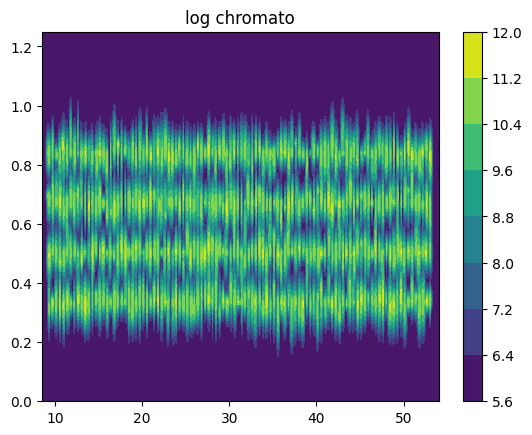

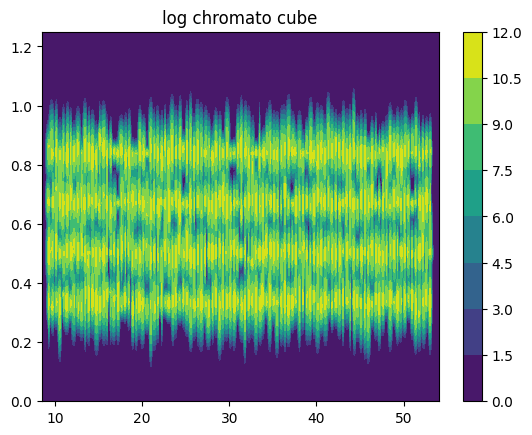

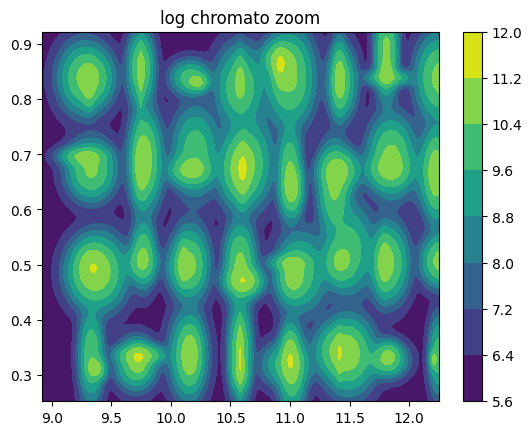

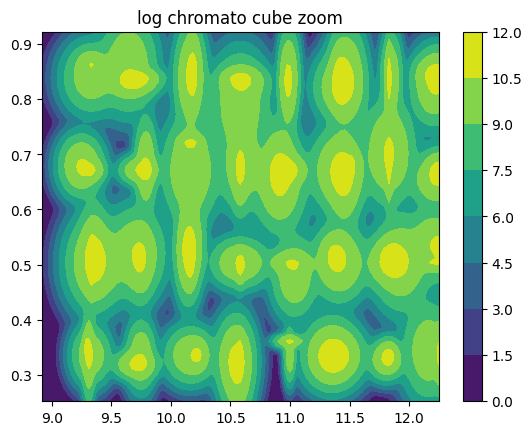

In [315]:
plot.visualizer((chromato_TIC, time_rn), log_chromato=True, title="log chromato")
plot.visualizer((chrom, time_rn),  log_chromato=True, title="log chromato cube")
plot.visualizer((chromato_TIC, time_rn), center_pt=[100, 70], center_pt_window_1=80, center_pt_window_2=40, log_chromato=True, title="log chromato zoom")
plot.visualizer((chrom, time_rn), center_pt=[100, 70], center_pt_window_1=80, center_pt_window_2=40, log_chromato=True, title="log chromato cube zoom")

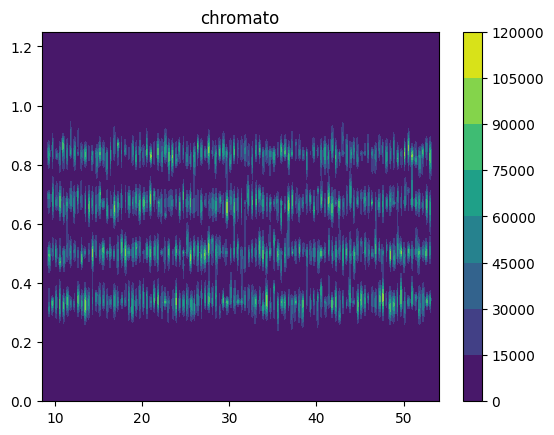

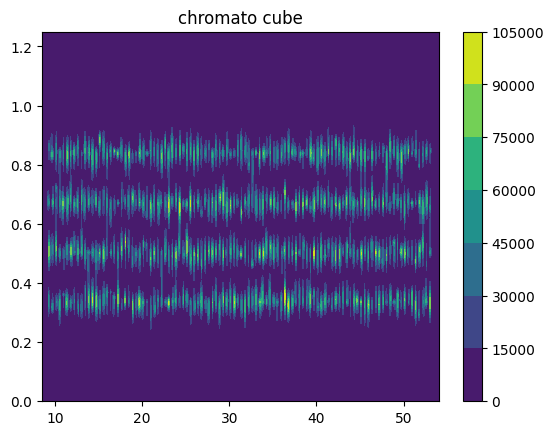

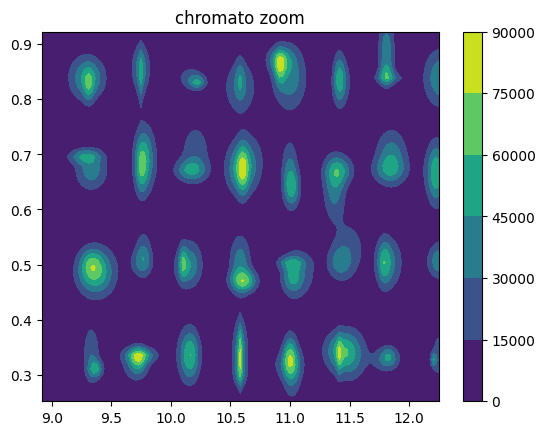

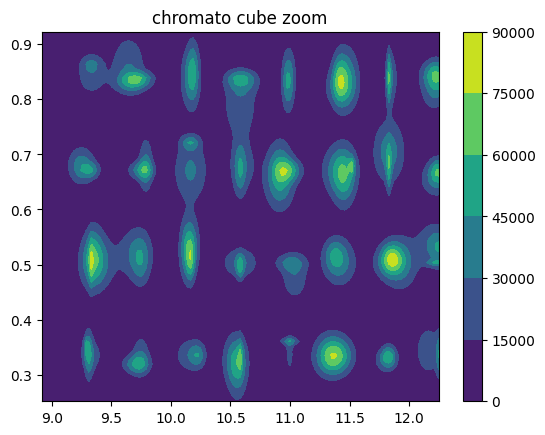

In [316]:
plot.visualizer((chromato_TIC, time_rn), log_chromato=False, title="chromato")
plot.visualizer((chrom, time_rn),  log_chromato=False, title="chromato cube")
plot.visualizer((chromato_TIC, time_rn), center_pt=[100, 70], center_pt_window_1=80, center_pt_window_2=40, log_chromato=False, title="chromato zoom")
plot.visualizer((chrom, time_rn), center_pt=[100, 70], center_pt_window_1=80, center_pt_window_2=40, log_chromato=False, title="chromato cube zoom")

# Test MCR-ALS

In [136]:
importlib.reload(peak_simulation)
new_chromato_TIC, new_chromato_cube, params, spectra=peak_simulation.create_chromato_cube(chromato.shape, 3, mu_center=[], center_dist=4, size=80)
print(params['peaks_mu'])

spectrum shape:  366
spectrum shape:  138
43 499
cube shape:  (2187, 150, 457)
[[55, 64], [56, 65], [57, 66]]


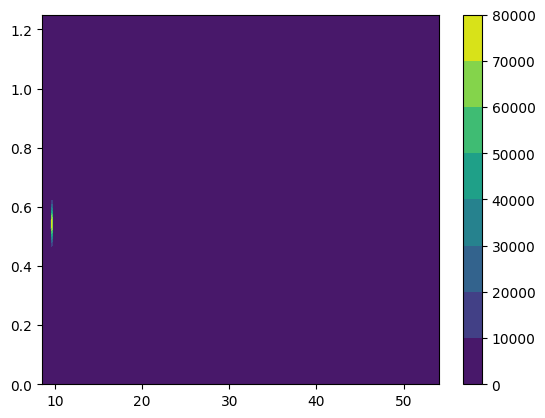

In [137]:
plot.visualizer((new_chromato_TIC, time_rn), log_chromato=False)

In [177]:
u = peak_detection.peak_detection(chromato_obj=(new_chromato_TIC, time_rn, spectra_obj), spectra=None, chromato_cube=None, seuil=0.1, ABS_THRESHOLDS=None, method='peak_local_max')
u_in_chromato=projection.matrix_to_chromato(u, time_rn, 1.25, chromato.shape)
u, u_in_chromato

(array([[56, 65]], dtype=int64), array([[9.66559572, 0.54530201]]))

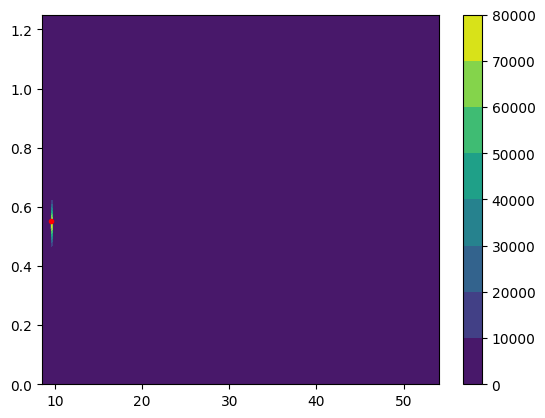

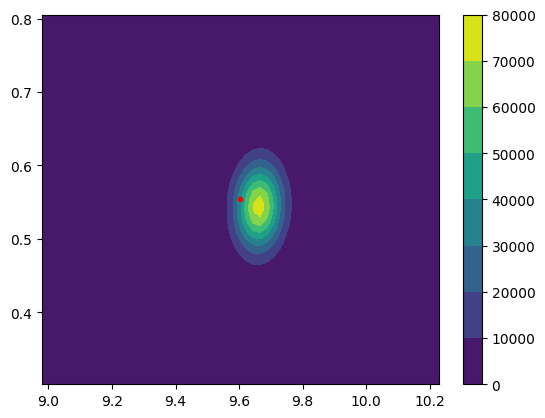

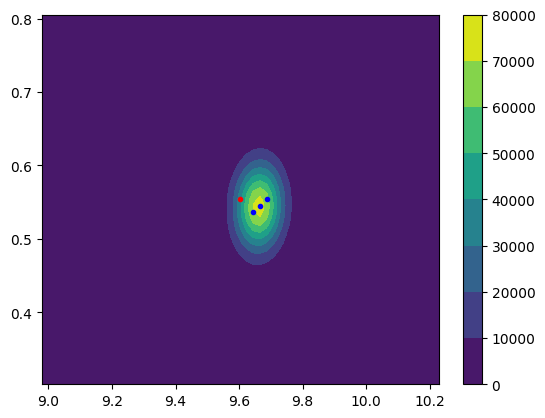

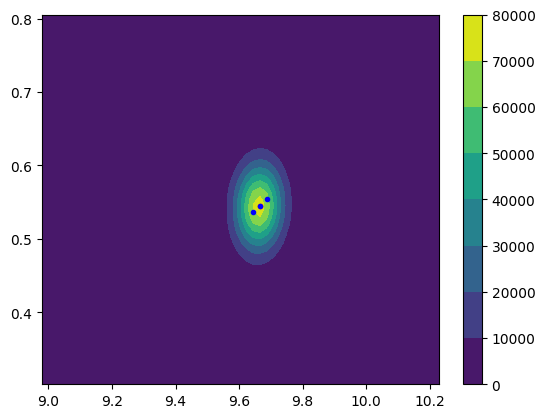

In [139]:
peaks_mu_in_chromato=projection.matrix_to_chromato(np.array(params['peaks_mu']), time_rn, 1.25, chromato.shape)
peaks_center_in_chromato=points=projection.matrix_to_chromato(np.array([params['peaks_center']]), time_rn, 1.25, chromato.shape)
plot.visualizer(chromato_obj=(new_chromato_TIC,time_rn), log_chromato=False, points=peaks_center_in_chromato)
plot.visualizer(chromato_obj=(new_chromato_TIC, time_rn), log_chromato=False, points=peaks_center_in_chromato,center_pt=params['peaks_center'], center_pt_window_1=30,center_pt_window_2=30)
plot.visualizer(chromato_obj=(new_chromato_TIC, time_rn), log_chromato=False, contour=peaks_mu_in_chromato, points=peaks_center_in_chromato, center_pt=params['peaks_center'], center_pt_window_1=30,center_pt_window_2=30)
plot.visualizer(chromato_obj=(new_chromato_TIC, time_rn), log_chromato=False, contour=peaks_mu_in_chromato, points=u_in_chromato, center_pt=params['peaks_center'], center_pt_window_1=30,center_pt_window_2=30)

In [140]:
def tmp(chromato, coordinates, coordinate, threshold=0.25):
    mask = np.zeros(chromato.shape, dtype=bool)
    mask[tuple(coordinates.T)] = True
    markers, _ = ndi.label(mask)
    peak_apex_int = chromato[coordinate[0]][coordinate[1]]
    img = np.where(chromato < threshold * peak_apex_int, 0, 1)
    labels = watershed(-chromato, markers, mask=img)
    coordinate_label = labels[coordinate[0]][coordinate[1]]
    blob = np.where(labels != coordinate_label, 0, 1)
    cds = []
    for cd in np.argwhere(blob == 1):
        cds.append([cd[0], cd[1]])
    return cds
def compute_spectra_array(cds, chromato_cube):
    spc=[]
    for i,cd in enumerate(cds):
        spc.append(mass_spec.read_spectrum_from_chromato_cube(cd, chromato_cube=chromato_cube))
    return np.array(spc)

In [178]:
#search zone
cds = np.array(tmp(new_chromato_TIC, u, u[0], threshold=0.3))
#spectra in search zone
spc=compute_spectra_array(cds, new_chromato_cube)
cds.shape, spc.shape

((85, 2), (85, 457))

In [179]:
np.array(params['peaks_mu'])

array([[55, 64],
       [56, 65],
       [57, 66]])

In [196]:
id=[]
for i, cd in enumerate(cds):
    if ((cd[0] == params['peaks_mu'][0][0] and cd[1] == params['peaks_mu'][0][1]) or (cd[0] == params['peaks_mu'][1][0] and cd[1] == params['peaks_mu'][1][1]) or (cd[0] == params['peaks_mu'][2][0] and cd[1] == params['peaks_mu'][2][1])):
        print(i)
        id.append(i)


29
44
59


In [197]:
from pymcr.mcr import McrAR
mcrar = McrAR(max_iter=100)

In [198]:
mcrar.fit(spc, ST=np.array([spc[id[0]], spc[id[1]]]))

Max iterations reached (100).


In [199]:
mv=np.linspace(params['range'][0], params['range'][1], params['range'][1] - params['range'][0] + 1)

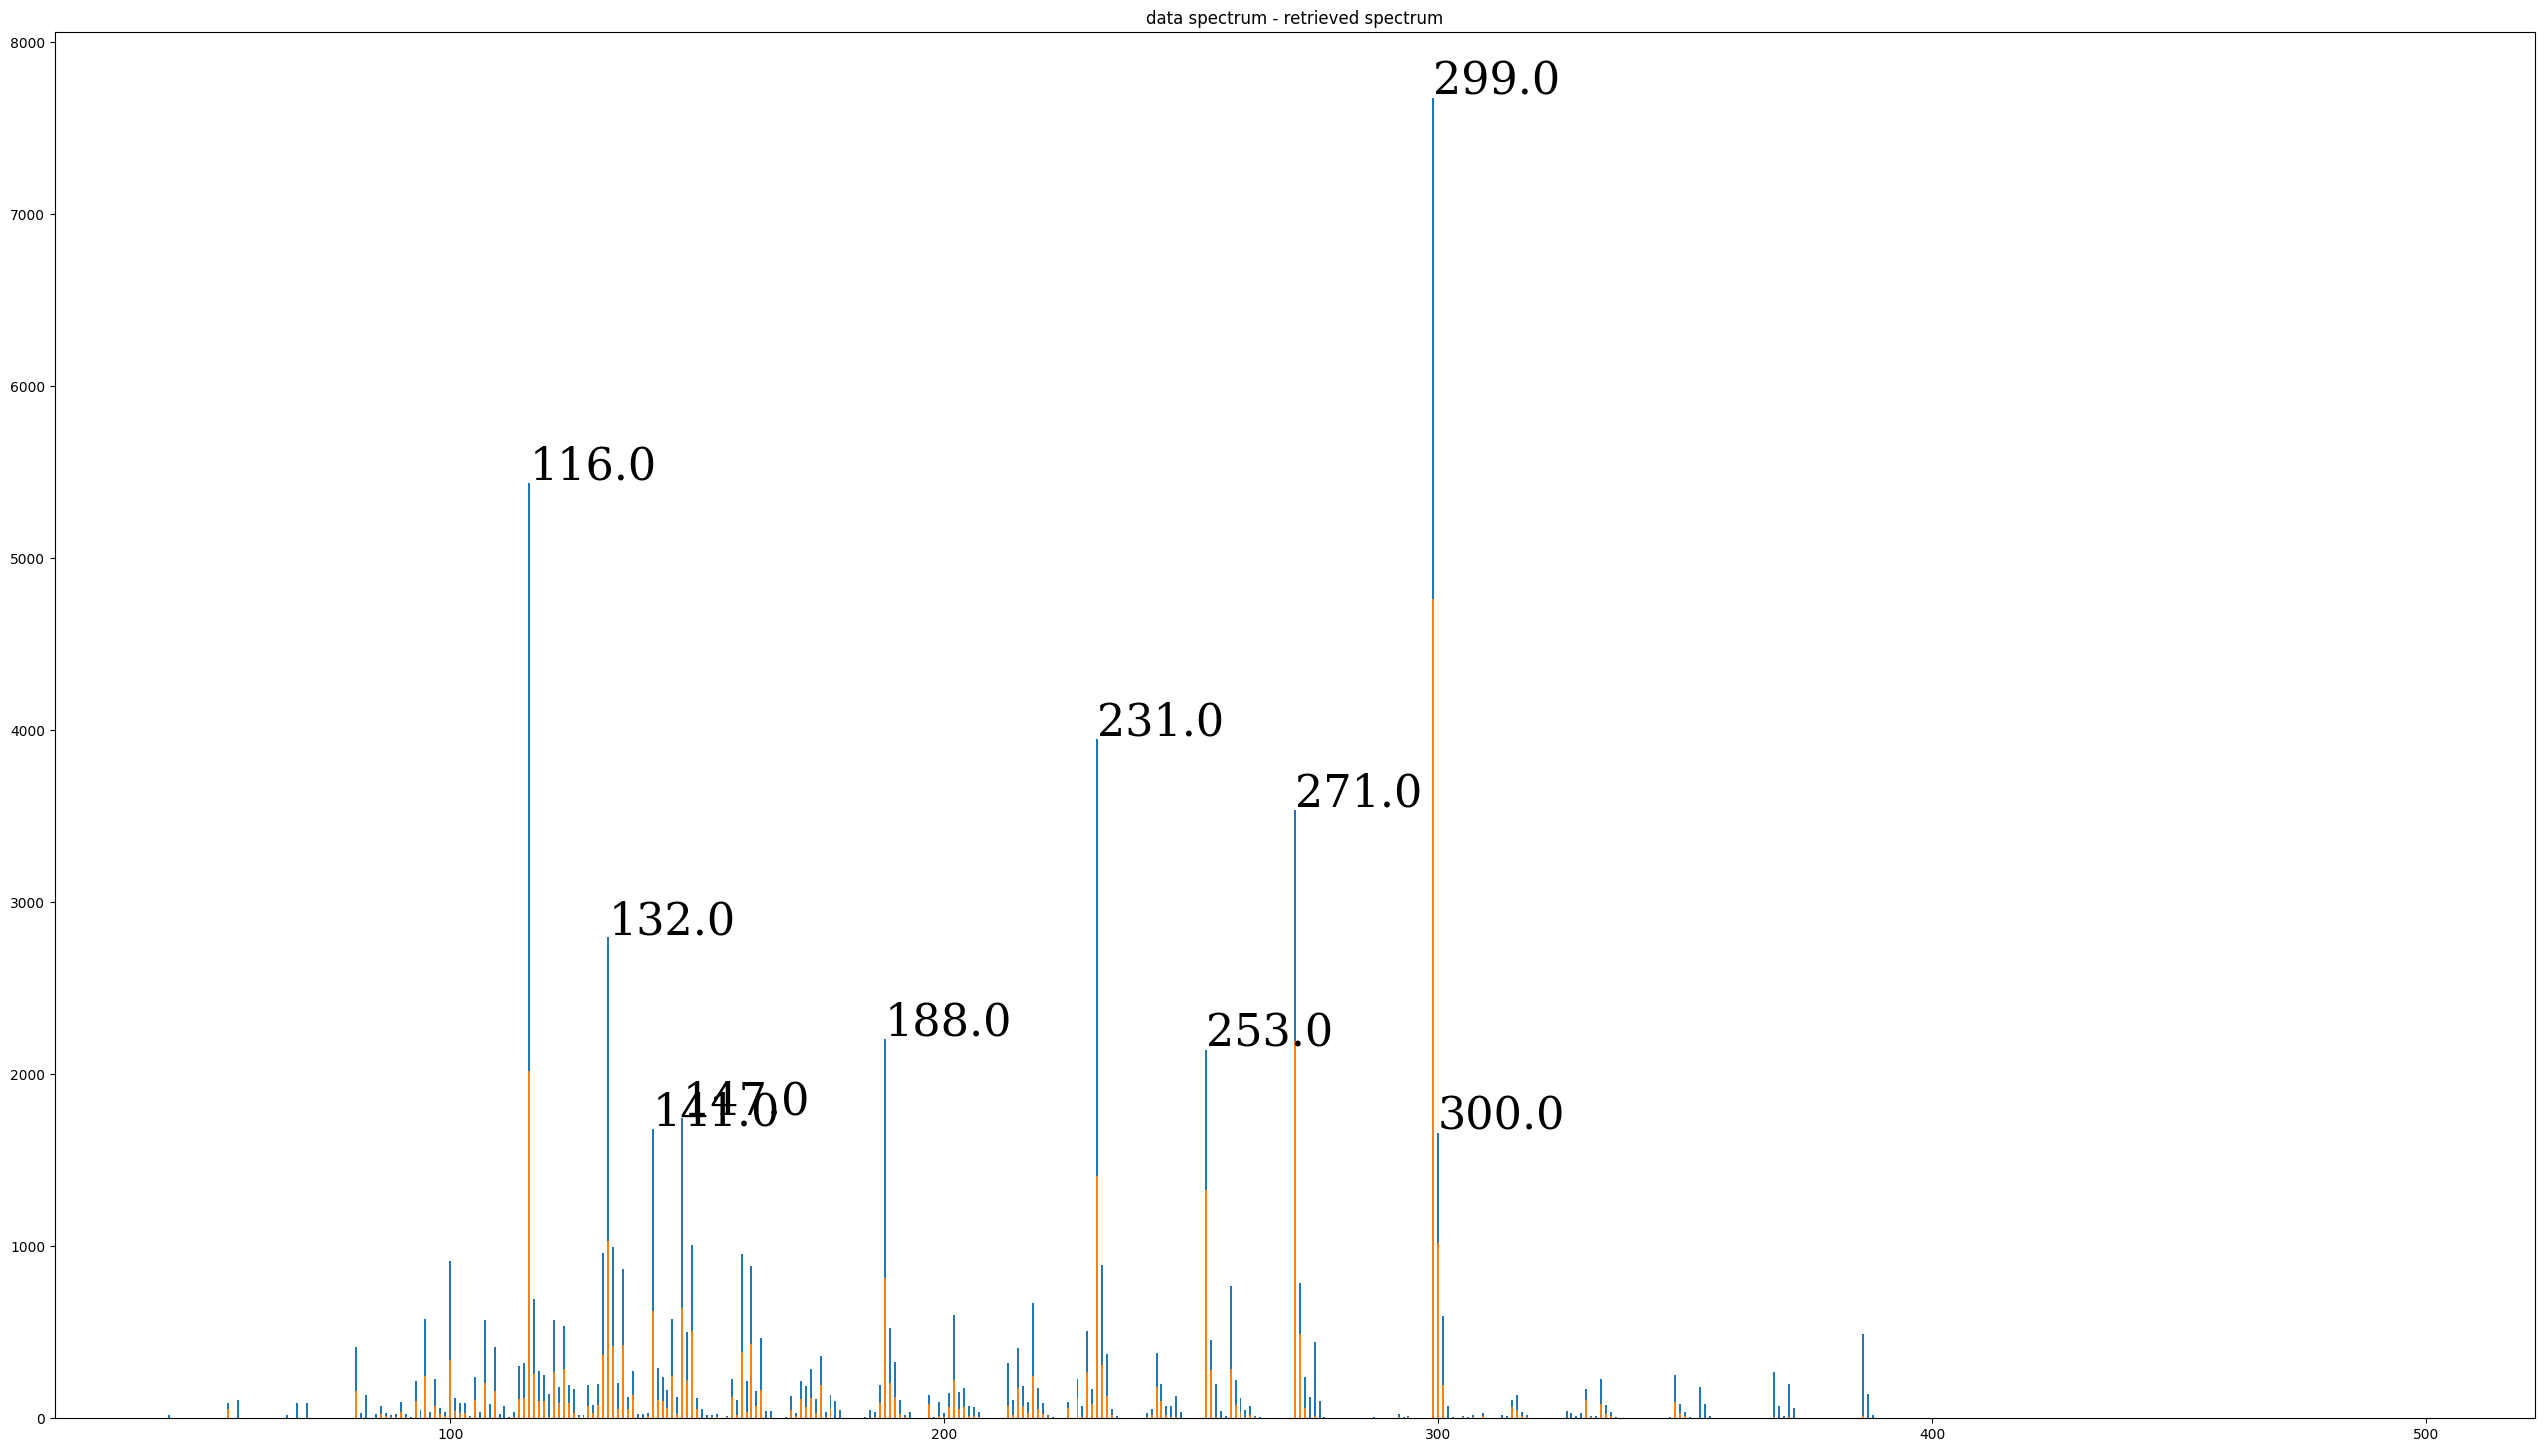

In [200]:
plot.mass_overlay([mv, mv], [spc[id[0]], mcrar.ST_[0]], title="data spectrum - retrieved spectrum")

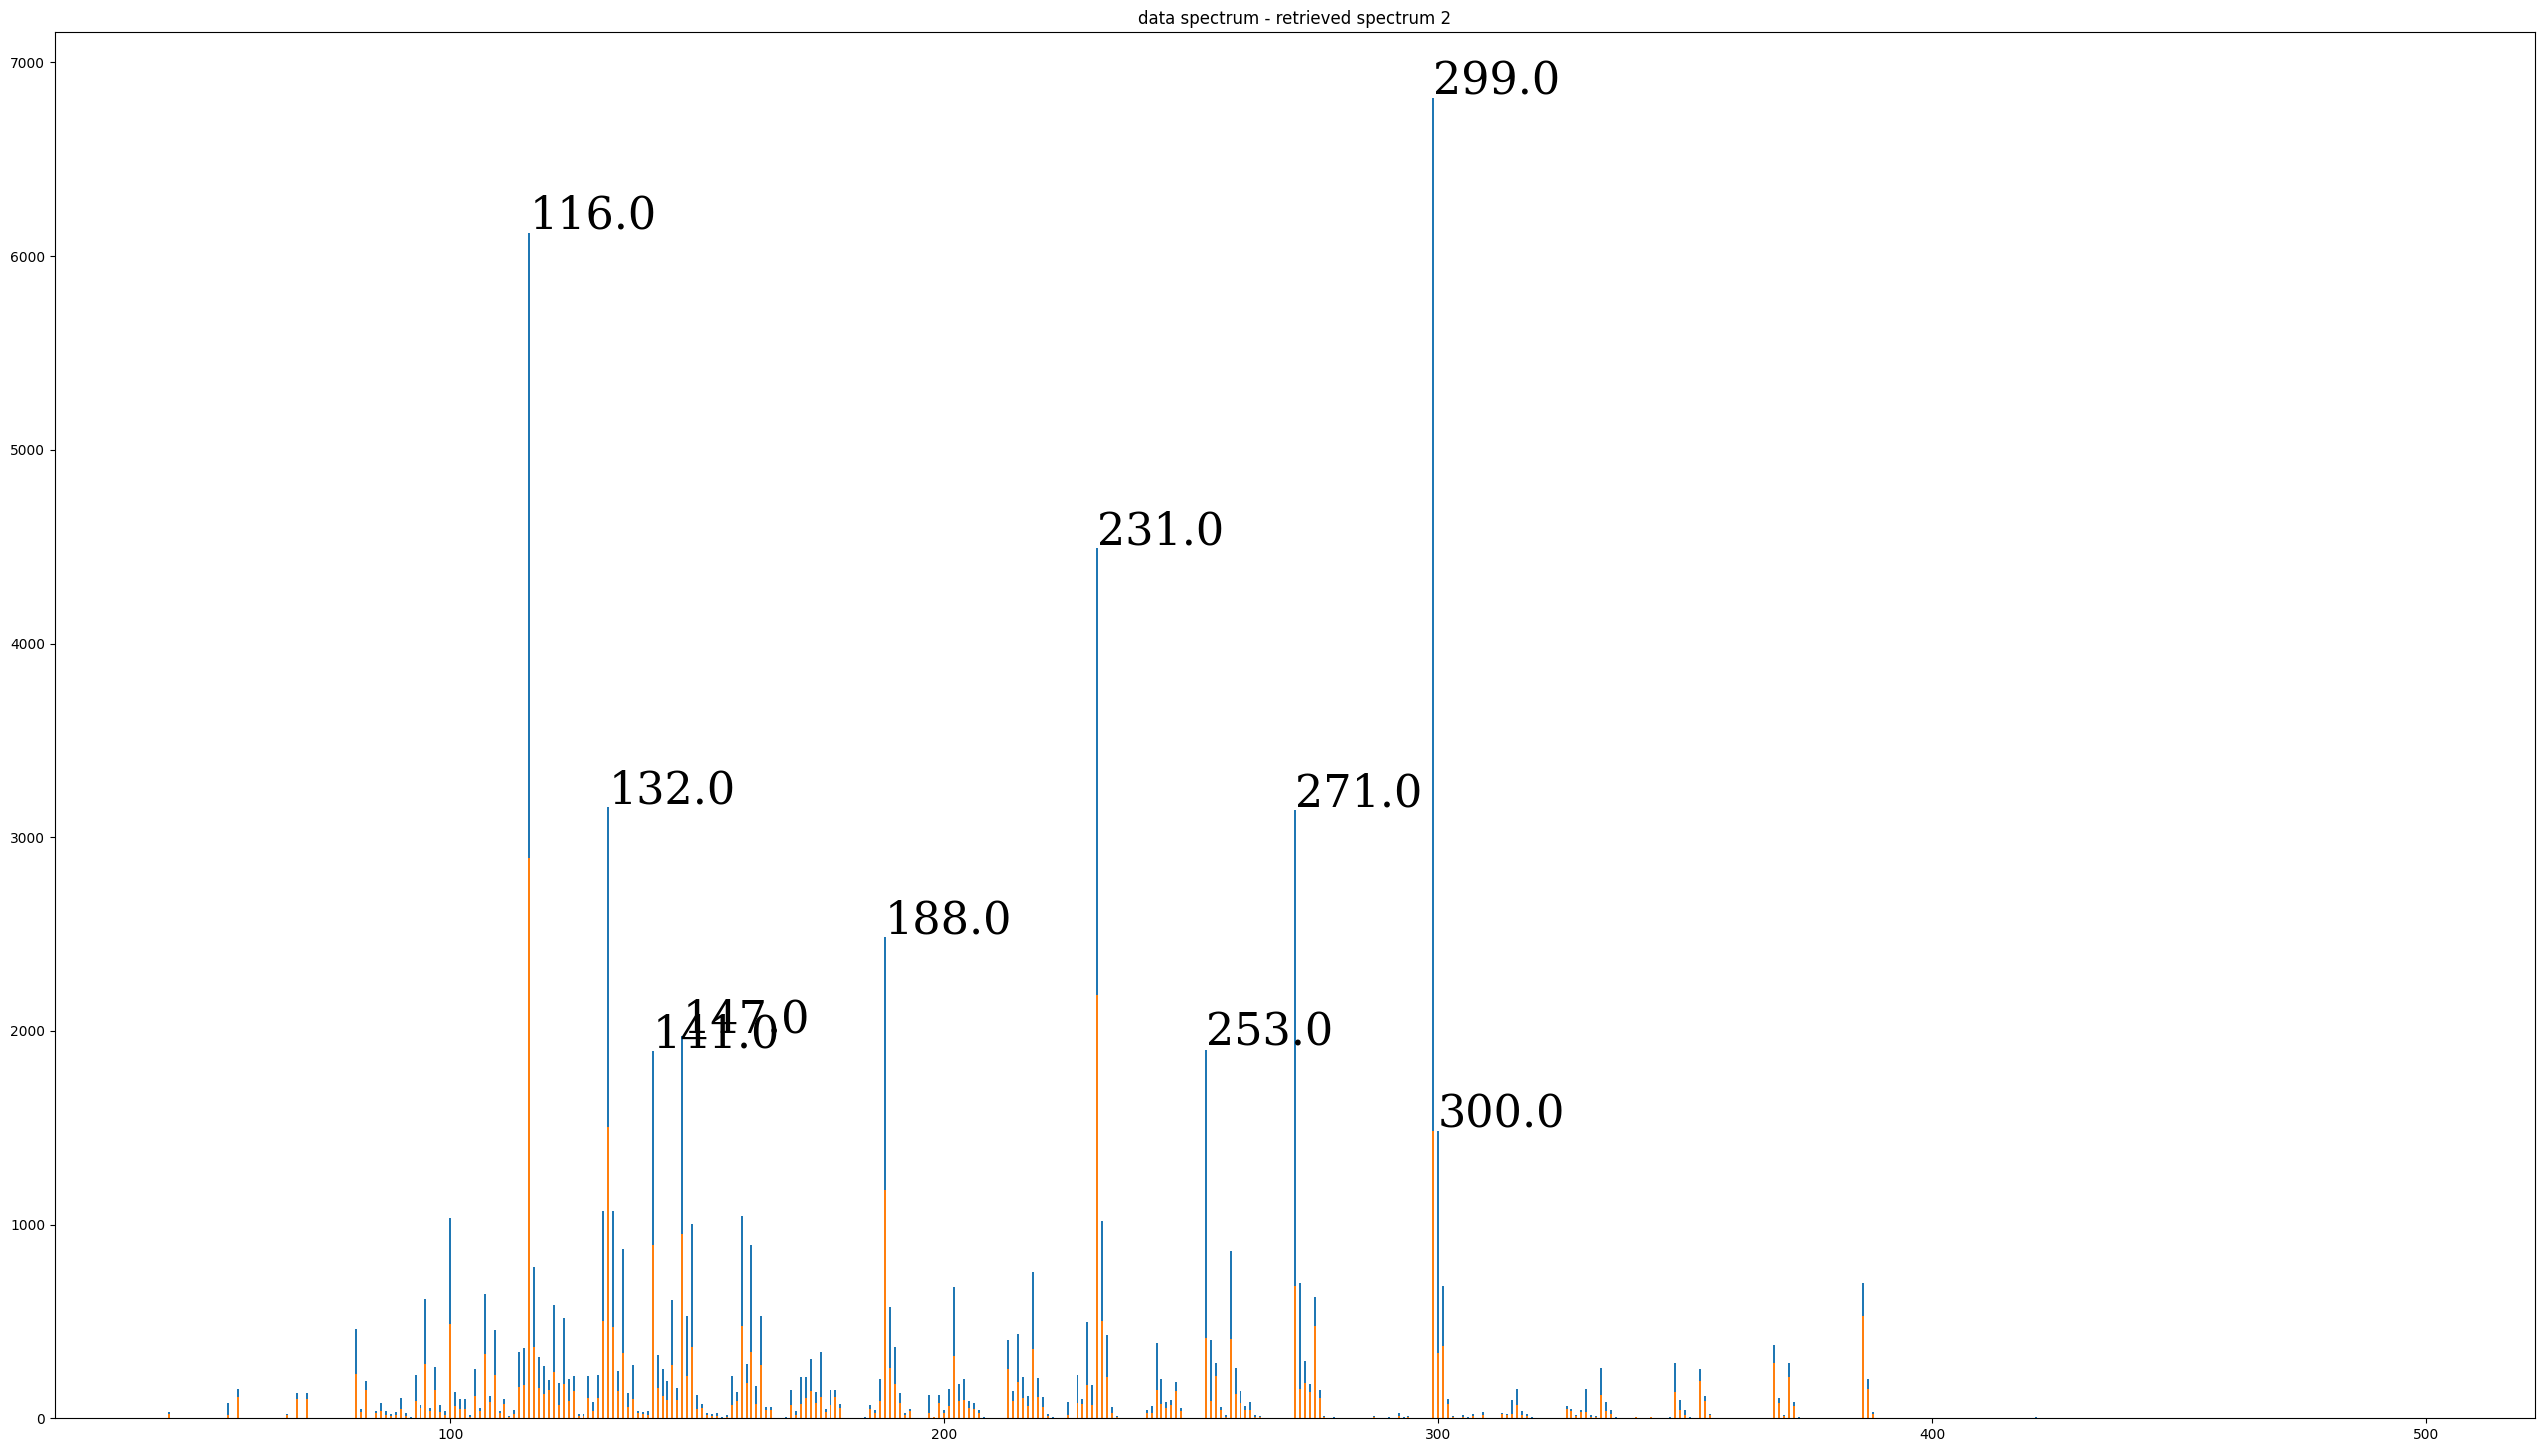

In [201]:
plot.mass_overlay([mv, mv], [spc[id[1]], mcrar.ST_[1]], title="data spectrum - retrieved spectrum 2")

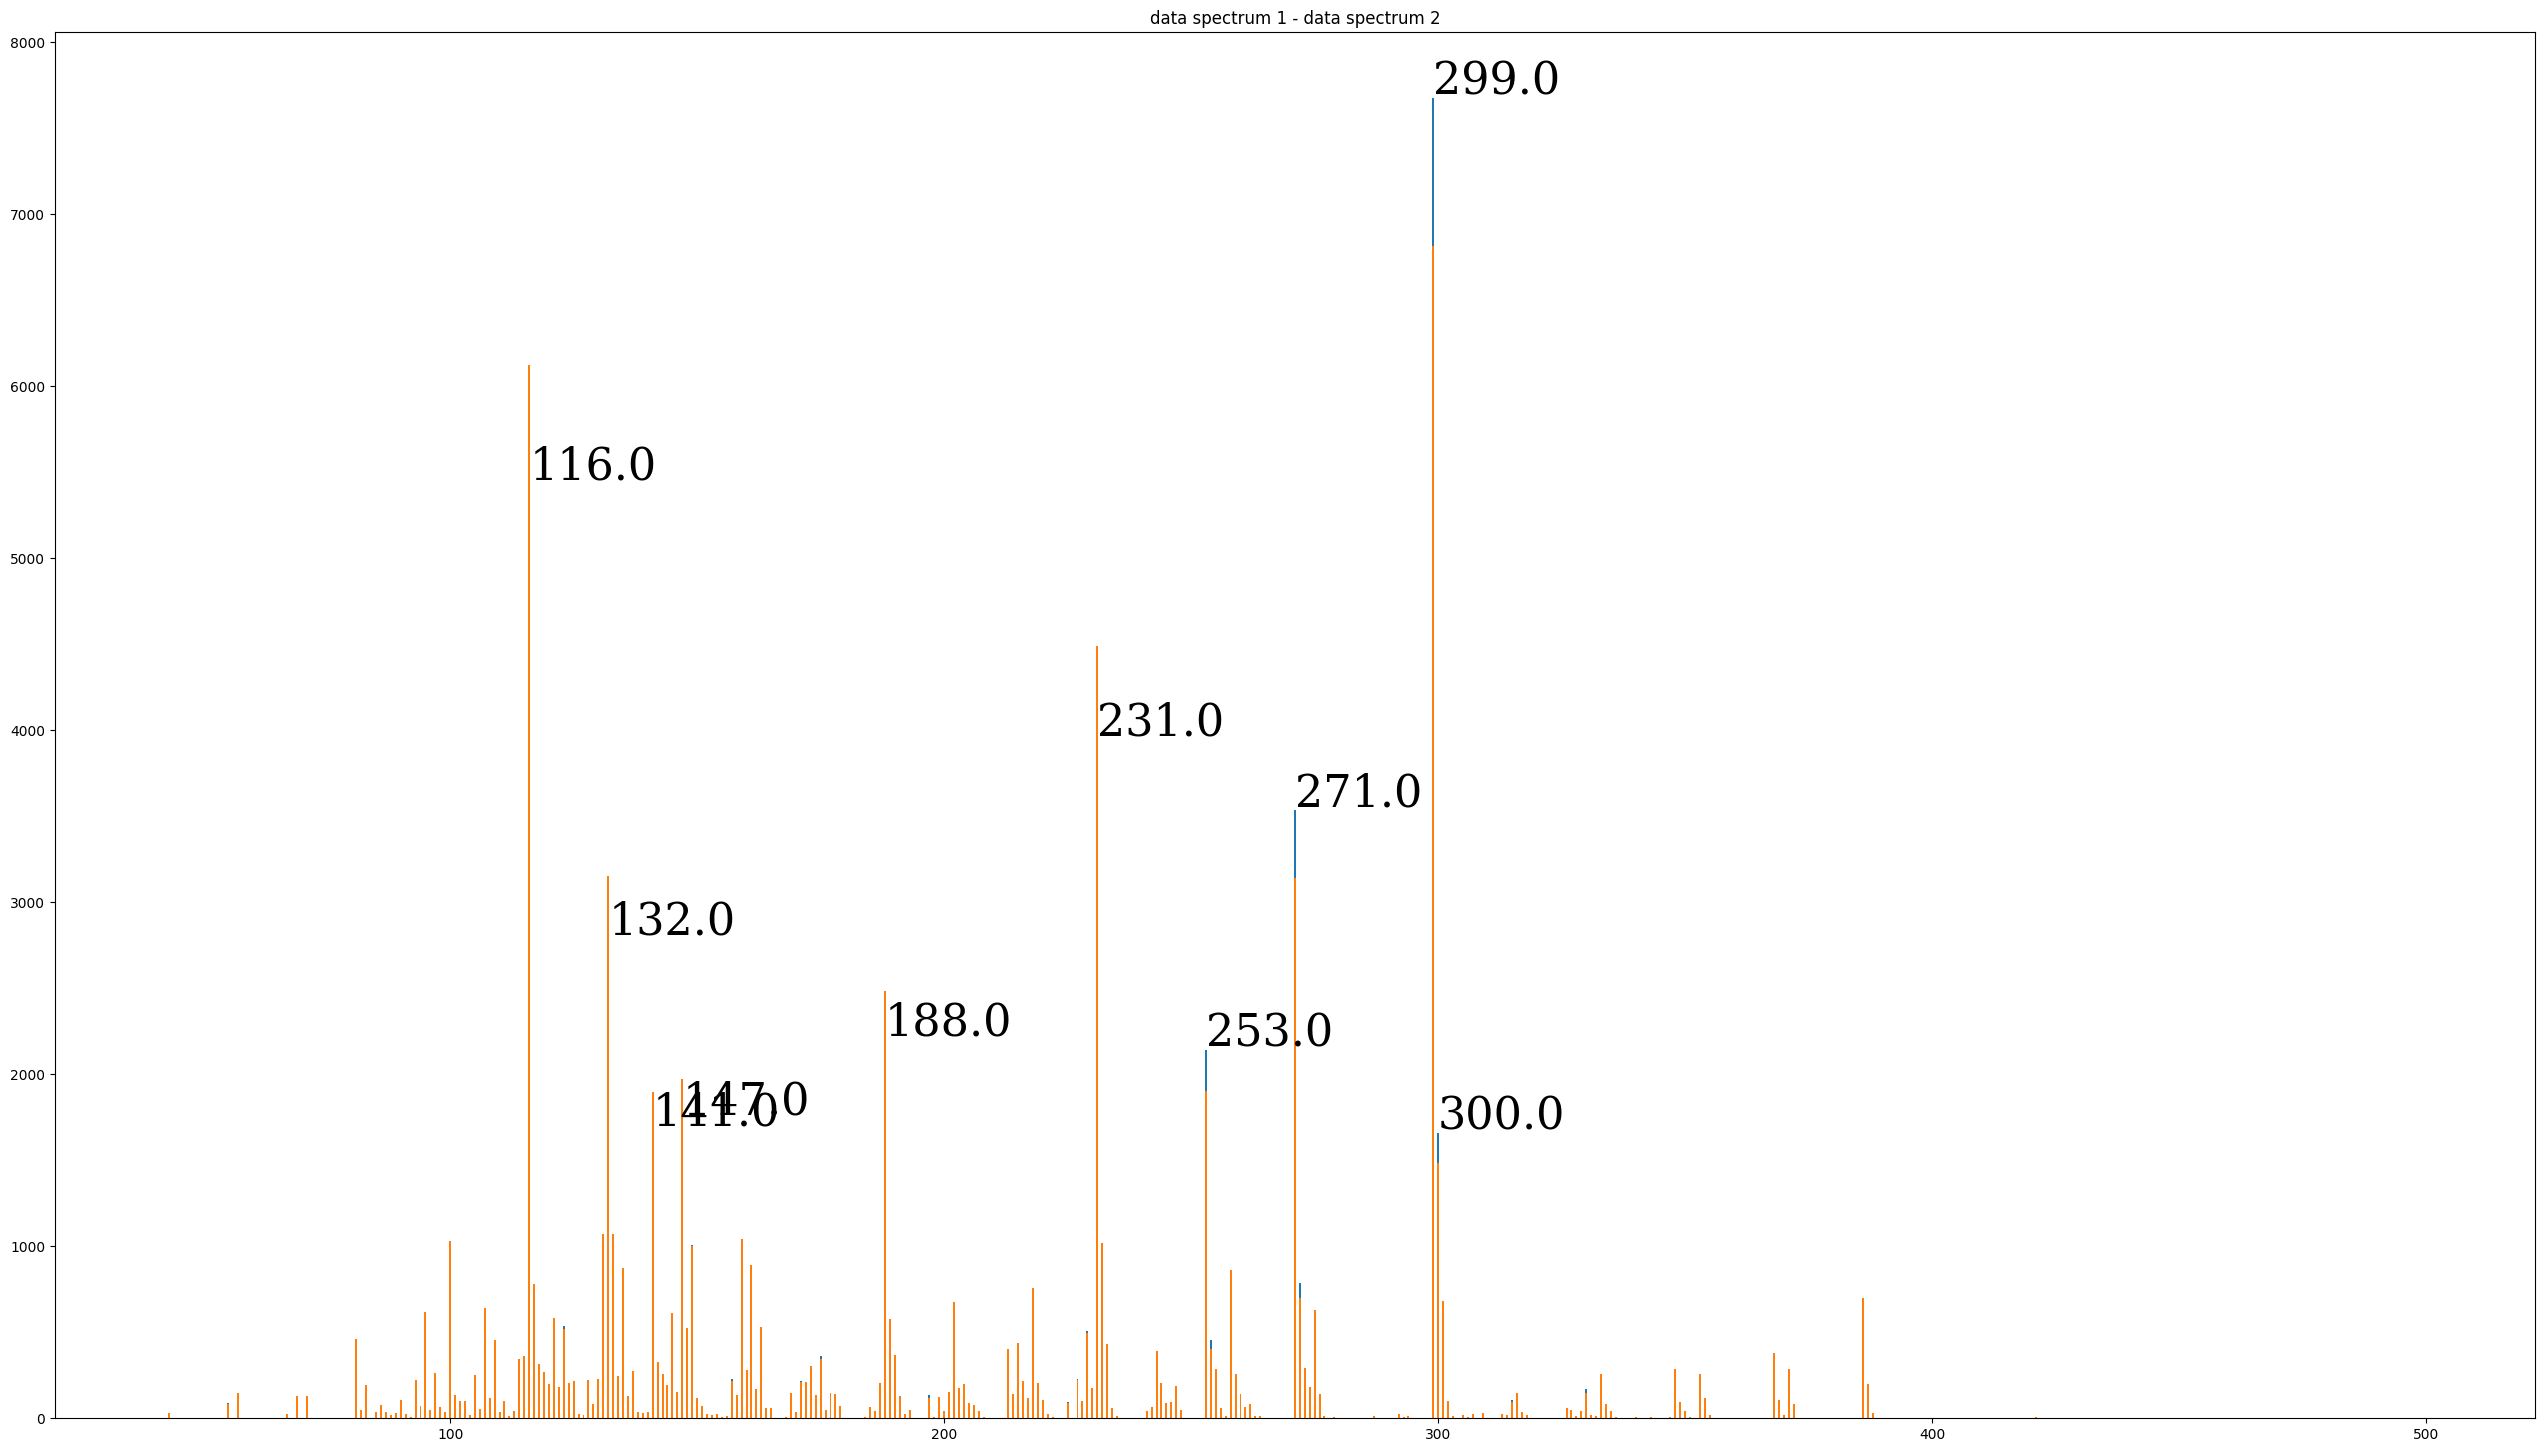

In [202]:
plot.mass_overlay([mv, mv], [spc[id[0]], spc[id[1]]], title="data spectrum 1 - data spectrum 2")

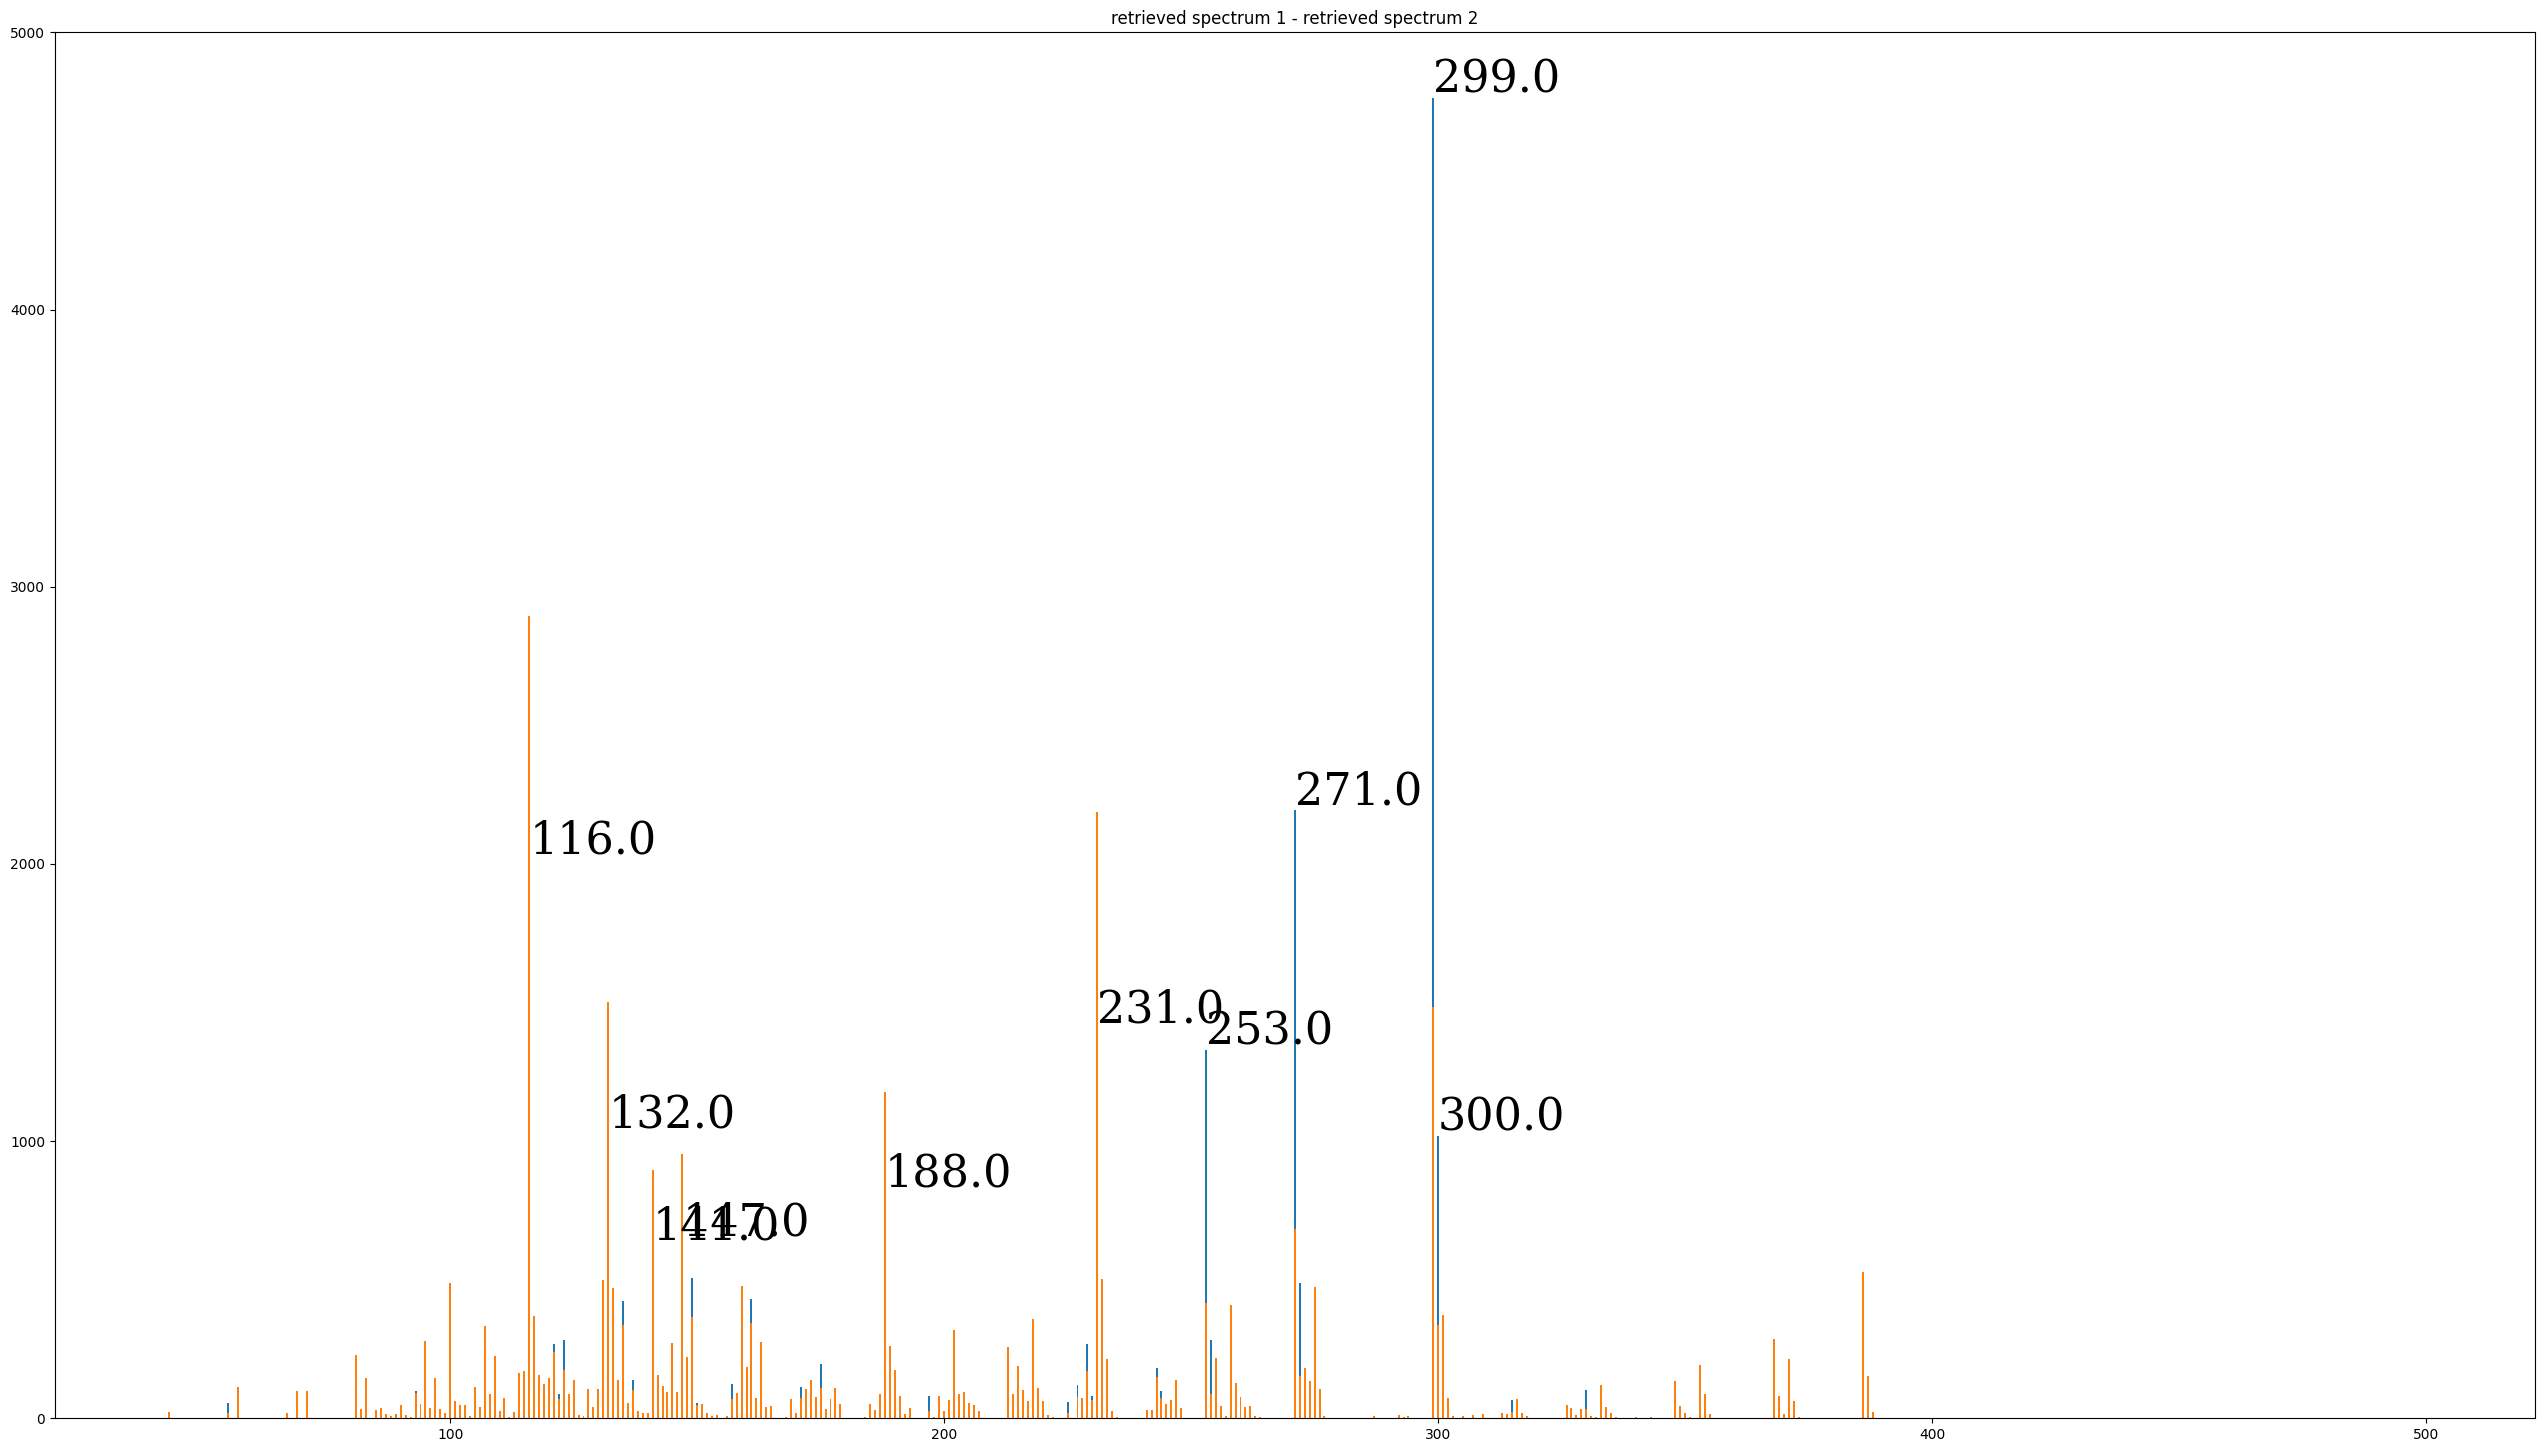

In [203]:
plot.mass_overlay([mv, mv], [mcrar.ST_[0], mcrar.ST_[1]], title="retrieved spectrum 1 - retrieved spectrum 2")

Les deux spectres sont très similaires dans les données mais les vrais spectres pas du tout

In [204]:
print("similarity true spectra - point spectra",utils.compute_spectra_similarity([mv, spc[0]], [mv,spc[1]]))
print("similarity true spectra - point spectra",utils.compute_spectra_similarity([mv, spectra[0][1]], [mv,spectra[1][1]]))

similarity true spectra - point spectra 0.9999102339613317
similarity true spectra - point spectra 0.007995534936004306


95.6% similarité entre le spectre retrouvé par mcrar et le vrai spectre
99.9% similarité entre le spectre calculé par mcrar et le spectre dans les données
95.9% similarité entre le spectre dans les données et le vrai spectre

Il y a donc un gain de 4%

In [205]:
i=0
print("similarity ST spectra - true spectra", utils.compute_spectra_similarity([mv, mcrar.ST_[i]], [mv,spectra[i][1]])) 
print("similarity ST spectra - point spectra", utils.compute_spectra_similarity([mv, mcrar.ST_[i]], [mv,spc[i]]))
print("similarity true spectra - point spectra", utils.compute_spectra_similarity([mv, spc[i]], [mv,spectra[i][1]]))

similarity ST spectra - true spectra 0.9566027457882619
similarity ST spectra - point spectra 0.9993872235726888
similarity true spectra - point spectra 0.9590555665827027


77.1% similarité entre le spectre retrouvé par mcrar et le vrai spectre
75.11% similarité entre le spectre calculé par mcrar et le spectre dans les données
30.0% similarité entre le spectre dans les données et le vrai spectre

Il y a donc un gain de ~37%

In [206]:
i=1
print("similarity ST spectra - true spectra", utils.compute_spectra_similarity([mv, mcrar.ST_[i]], [mv,spectra[i][1]])) 
print("similarity ST spectra - point spectra", utils.compute_spectra_similarity([mv, mcrar.ST_[i]], [mv,spc[i]]))
print("similarity true spectra - point spectra", utils.compute_spectra_similarity([mv, spc[i]], [mv,spectra[i][1]]))

similarity ST spectra - true spectra 0.7712595159896426
similarity ST spectra - point spectra 0.751190731418008
similarity true spectra - point spectra 0.3006914096071651


# Test Hist Cd

In [305]:
new_chromato_cube_noisy=peak_simulation.add_noise_3D('gauss',new_chromato_cube)

In [306]:
u3d = peak_detection.peak_detection(chromato_obj=(new_chromato_TIC, time_rn, spectra_obj), spectra=None, chromato_cube=new_chromato_cube_noisy, seuil=0.1, ABS_THRESHOLDS=0.1, method='peak_local_max', mode='3D', cluster=False)
u_in_chromato_3d=projection.matrix_to_chromato(u3d, time_rn, 1.25, chromato.shape)
u3d, u_in_chromato_3d

(array([[55, 64],
        [56, 65],
        [57, 66]], dtype=int64),
 array([[9.64478151, 0.53691275],
        [9.66559572, 0.54530201],
        [9.68640992, 0.55369128]]))

In [307]:
params

{'peaks_mu': [[55, 64], [56, 65], [57, 66]],
 'peaks_sigma': [(2.2903981785826395, 4.633156178479622),
  (2.2903981785826395, 4.633156178479622),
  (2.2903981785826395, 4.633156178479622)],
 'spectra_id': ['HMDB0000016', 'HMDB0000168', 'HMDB0000067'],
 'peaks_center': [53, 66],
 'center_dist': 4,
 'range': (43, 499)}

In [155]:
"""umpm = peak_detection.peak_detection(chromato_obj=(new_chromato_TIC, time_rn, spectra_obj), spectra=None, chromato_cube=new_chromato_cube_noisy, seuil=0.1, ABS_THRESHOLDS=0.5, method='peak_local_max', mode='mass_per_mass', cluster=False)
u_in_chromato_mpm=projection.matrix_to_chromato(umpm, time_rn, 1.25, chromato.shape)
umpm, u_in_chromato_mpm"""

"umpm = peak_detection.peak_detection(chromato_obj=(new_chromato_TIC, time_rn, spectra_obj), spectra=None, chromato_cube=new_chromato_cube_noisy, seuil=0.1, ABS_THRESHOLDS=0.5, method='peak_local_max', mode='mass_per_mass', cluster=False)\nu_in_chromato_mpm=projection.matrix_to_chromato(umpm, time_rn, 1.25, chromato.shape)\numpm, u_in_chromato_mpm"

In [156]:
from skimage.feature import peak_local_max

In [157]:
m = peak_local_max(new_chromato_cube_noisy, threshold_rel=0.1)

In [158]:
m, len(m)

(array([[256,  55,  64],
        [ 73,  56,  65],
        [188,  56,  65],
        [228,  55,  64],
        [ 89,  56,  65],
        [145,  56,  65],
        [210,  55,  64],
        [104,  56,  65],
        [ 98,  56,  65],
        [116,  56,  65],
        [ 57,  56,  65],
        [106,  55,  64],
        [118,  56,  65],
        [ 92,  56,  65],
        [215,  56,  65],
        [343,  57,  66]], dtype=int64),
 16)

In [159]:
peak_local_max(new_chromato_TIC, threshold_rel=0.1)

array([[56, 65]], dtype=int64)

In [135]:
params

{'peaks_mu': [[1559, 100], [1560, 99]],
 'peaks_sigma': [(1.2961646009958092, 1.453631026851336),
  (1.2961646009958092, 1.453631026851336)],
 'spectra_id': ['HMDB0000149', 'HMDB0000039'],
 'peaks_center': [1557, 98],
 'center_dist': 4,
 'range': (14, 88)}

# Test Real Chrom

In [207]:
full_spectra=mass_spec.read_full_spectra_centroid(spectra_obj=spectra_obj)

--- 225.70808911323547 seconds --- to compute full spectra centroid


In [208]:
spectra, debuts, fins=full_spectra

In [210]:
chromato_cube=read_chroma.full_spectra_to_chromato_cube(full_spectra=full_spectra, spectra_obj=spectra_obj)

In [211]:
chromato_no_bl=baseline_correction.chromato_no_baseline(chromato)
chromato_cube=np.array(baseline_correction.chromato_cube_corrected_baseline(chromato_cube))

In [212]:
from skimage.restoration import estimate_sigma
sigma=estimate_sigma(chromato, channel_axis=None)
MIN_SEUIL=5*sigma*100 / np.max(chromato)
print(MIN_SEUIL)

0.027154168780598686


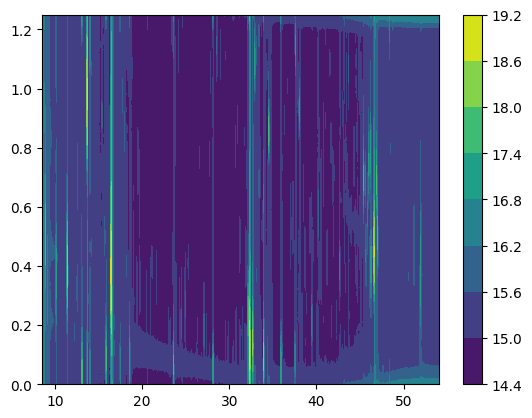

In [213]:
plot.visualizer((chromato, time_rn))

In [215]:
u3d = peak_detection.peak_detection(chromato_obj=(chromato_no_bl, time_rn, spectra_obj), spectra=None, chromato_cube=chromato_cube, seuil=0.1, ABS_THRESHOLDS=0.1, method='peak_local_max', mode='3D', cluster=False)
u_in_chromato_3d=projection.matrix_to_chromato(u3d, time_rn, 1.25, chromato.shape)
u3d, u_in_chromato_3d

(array([[  20,   59],
        [  20,   61],
        [ 141,   47],
        [ 141,   49],
        [ 222,    5],
        [ 250,  115],
        [ 250,  116],
        [ 250,  117],
        [ 250,  118],
        [ 250,  119],
        [ 250,  122],
        [ 355,   10],
        [ 384,   42],
        [ 384,   44],
        [ 384,   46],
        [ 384,   48],
        [ 384,   51],
        [ 384,   53],
        [ 384,   57],
        [ 384,   63],
        [ 384,   64],
        [ 385,   12],
        [ 484,   10],
        [ 726,    7],
        [ 944,    5],
        [ 944,    6],
        [1137,   27],
        [1137,   29],
        [1142,    9],
        [1146,   14],
        [1146,   15],
        [1146,   20],
        [1146,   25],
        [1163,   16],
        [1163,   20],
        [1174,  130],
        [1223,   11],
        [1223,   13],
        [1251,  102],
        [1318,    7],
        [1773,   83],
        [1773,   86],
        [1812,   93],
        [1814,   48],
        [1831,   52],
        [1

In [227]:
u=peak_local_max(chromato_no_bl, threshold_rel=0.1)
u_in_chromato=projection.matrix_to_chromato(u, time_rn=time_rn, mod_time=1.25, chromato_dim=chromato.shape)

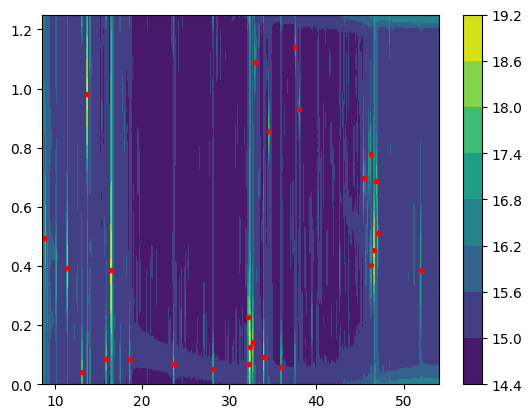

In [228]:
plot.visualizer((chromato, time_rn), points=u_in_chromato)

In [232]:
u3d=peak_local_max(chromato_cube, threshold_rel=0.1)
u3d_in_chromato=projection.matrix_to_chromato(u3d[:,1:], time_rn=time_rn, mod_time=1.25, chromato_dim=chromato.shape)

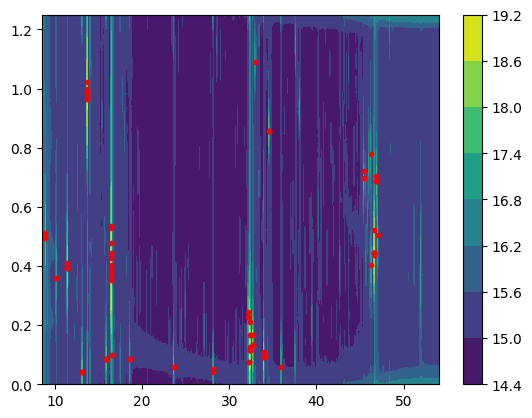

In [233]:
plot.visualizer((chromato, time_rn), points=u3d_in_chromato)

In [240]:
len(u), len(u3d), len(np.unique(u3d[:,1:]))

(26, 87, 70)

In [287]:
hist=np.zeros_like(chromato)
for pt in u3d:
    hist[pt[1], pt[2]]+=1

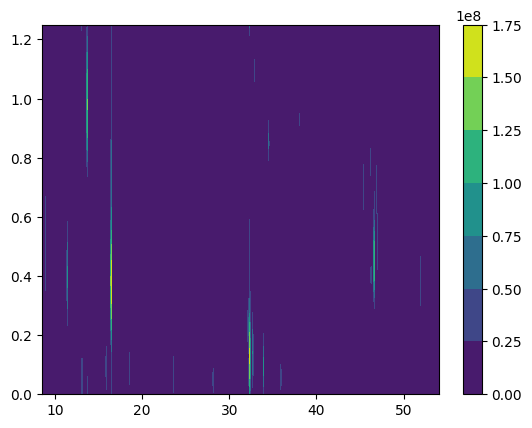

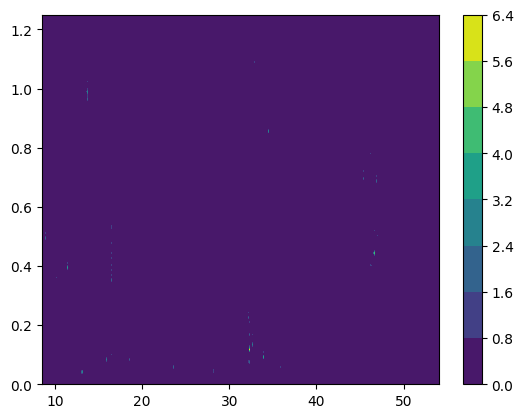

In [290]:
plot.visualizer((chromato, time_rn), log_chromato=False)
plot.visualizer((hist, time_rn), log_chromato=False)

In [297]:
u_hist=(peak_local_max(hist))
u_hist_in_chromato=projection.matrix_to_chromato(u_hist, time_rn=time_rn, mod_time=1.25, chromato_dim=chromato.shape)

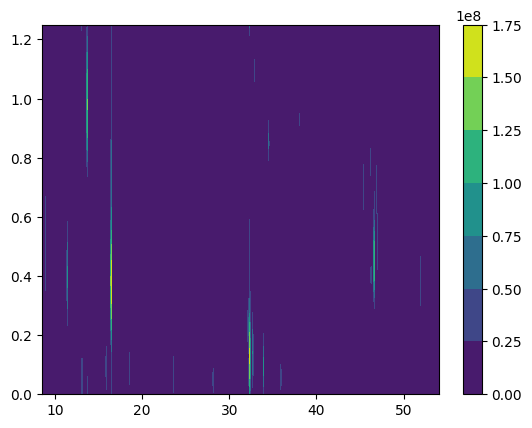

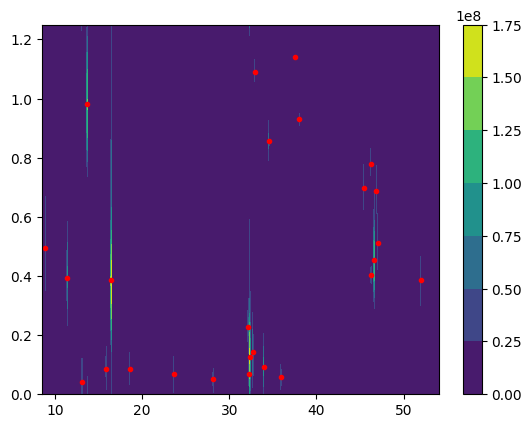

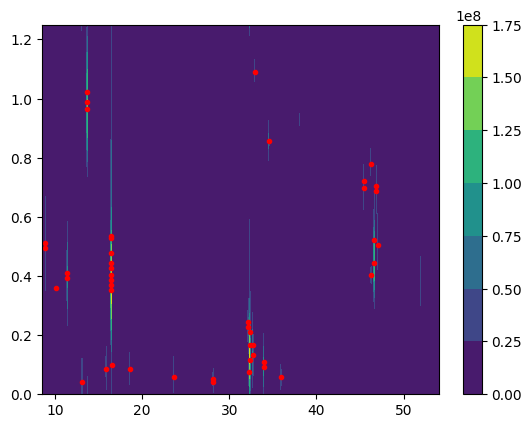

In [299]:
plot.visualizer((chromato, time_rn), log_chromato=False)
plot.visualizer((chromato, time_rn), log_chromato=False, points=u_in_chromato)
plot.visualizer((chromato, time_rn), log_chromato=False, points=u_hist_in_chromato)